# Libraries

Run the following cell when in google colab

In [ ]:
pip install --upgrade gensim

In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# When in colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# built in
import time
from itertools import cycle # for cycling through colors

# data and linear algebra
import numpy as np
import pandas as pd

# graphics & visualization
import seaborn as sns
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.sklearn

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

# sklearn NLP
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# TensorFlow & keras
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# gensim
import gensim
from gensim.models import KeyedVectors

# BERT
import os
import transformers
from transformers import *



## Options

In [7]:
import warnings
warnings.filterwarnings('ignore')

os.environ["TF_KERAS"]='1'


## Functions

The following cell contains the functions that we use in this notebook.

In [5]:
def choose_best_thres(y_true, y_pred_proba):
    '''
    Returns a threshold between 0.1 and 0.9
    which maximizes the macro average f1-score,
    for a multilabel classification problem.

    Parameters:
        - y_true: binary array
        - y_pred_proba: array
            returned by some_estimator.predict_proba()
    '''
    f1_thr = {}
    for t in np.linspace(0.1,0.9,9): # testing thresholds 0.2, 0.3, up to 0.8
        classif_rep = classification_report(
            y_true, 
            (y_pred_proba > t).astype(int),
            target_names=tag_list,
            output_dict=True)
        f1_thr[t] =  classif_rep['macro avg']['f1-score']

    # choose threshold for maximal f1-score
    thresh = round(max(f1_thr, key=f1_thr.get),1)
    print(f'Threshold that maximizes f1-score: {thresh}')

    return thresh


def plot_classif_report(classif_report, tag_list, model_name, dataset_name, vectorization):
    '''
    Plots precision, recall and f1-score for each tag in tag_list.

    Parameters:
        - classif_report: dict
            It is the output of sklearn.metrics.classification_report(y_true,y_pred)
            after a multi-label multi-output classification.
        - tag_list: list of str
            The list of tags of the classification.
        - model_name, dataset_name: str
            for the title of the plot
    '''
    global f1_sco
    n_tags = len(tag_list)

    fig = plt.figure(figsize=(10, 6))
    plt.grid(True)
    plt.xticks(range(1,len(tag_list)+1),tag_list)
    colors = ['blueviolet', 'darkorange', 'dodgerblue']

    for metric,color in zip(['precision', 'recall', 'f1-score'], colors):
        y = [classif_report[tag][metric] for tag in tag_list]
        plt.scatter(range(1,n_tags+1),y,label=metric, c=color)
    plt.legend()
    plt.ylim(0,1.1)
    plt.xticks(rotation=70)

    macro_prec = round(classif_report['macro avg']['precision'],2)
    macro_rec = round(classif_report['macro avg']['recall'],2)
    macro_f1 = round(classif_report['macro avg']['f1-score'],2)
    f1_sco = macro_f1

    plt.text(30, 
             0.05, 
             f'Macro avg\nprecision: {macro_prec}\nrecall: {macro_rec}\nf1-score: {macro_f1}',
             bbox={'facecolor':'white', 'alpha':0.5})
    plt.title(f'Some metrics by tag\nModel: {model_name}, set: {dataset_name}, vectorization: {vectorization}')
    plt.show()

def diplay_and_plot_report(y_true, y_pred, model_name, dataset_name, vectorization):
        '''
        Displays the classification report together with the metrics
        (from the mul-label, multi-output classification) and plots
        the metrics for each tag.

        Parameters:
                - y_true: array
                        The true labels
                - y_pred: array
                        The prefictions
                - model_name, dataset_name: str
                        For the title of the plot
        '''

        classif_rep = classification_report(
                y_true, 
                y_pred,
                target_names=tag_list,
                output_dict=True)
        classif_rep_displ = classification_report(
                y_true, 
                y_pred,
                target_names=tag_list,
                output_dict=False)
        print(f'Classifier: {model_name}\tDataset: {dataset_name}')
        print('-'*70)
        print(classif_rep_displ)
        plot_classif_report(classif_rep, tag_list, model_name, dataset_name, vectorization)

def compute_roc_data(y_true,y_pred_proba,tag_list):
    '''
    Computes the data necessary to plot the OneVsRest
    ROC curves of our multilabel classification.
    Returns dictionnaries: fpr, tpr, roc_auc

    Based on sckikit-learn's example: 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

    Parameters:
        - y_true: pd.DataFrame
        - y_pred: array
            returned by classification: predict probabilities
        - tag_list: list of str 
    '''
    global roc_auc_res

    n_tags = len(tag_list)
    # store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.values.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")


    for i in range(n_tags):
        fpr[i], tpr[i], _ = roc_curve(y_true.values[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_tags):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= n_tags

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    roc_auc_res = roc_auc["macro"]

    print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

    return fpr, tpr, roc_auc



def plot_roc_curves(
        fpr, tpr, roc_auc, model_name, dataset_name, vector_name,y_true,y_pred_proba):
    '''
    Plots the ROC curves of the OneVsRest classification
    for each tag.

    Based on scikit-learn's example:
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

    Parameters:
        - fpr, tpr, roc_auc: dict, dict, dict
            Output of the function compute_roc_data
        - model_name, dataset_name: str
            For the title of the plot
    '''
    

    fig, ax = plt.subplots(figsize=(6, 6))

    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=3,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=3,
    )

    # colors = cycle(["darkorange", 
    #                 'olivedrab', 
    #                 'lightseagreen',
    #                 'dodgerblue',
    #                 'slategray',
    #                 'blueviolet',
    #                 'indigo',
    #                 'mediumvioletred',
    #                 'lightgreen',
    #                 'lightpink'
    #                 ])
    
    colors = cycle(sns.color_palette("hls", 40))
    for (idx,class_id), color in zip(enumerate(tag_list), colors):
        RocCurveDisplay.from_predictions(
            y_true[f'tag_{class_id}'].values,
            y_pred_proba[:, idx],
            name=f"ROC curve for {class_id}",
            color=color,
            ax=ax,
        )

    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC curves and AUC for each tag to One-vs-Rest\nmodel: {model_name}, dataset: {dataset_name},\n vectorizarion: {vector_name}")
    plt.legend(loc='center left', bbox_to_anchor = (1,0.5))
    plt.show()

def plot_LDA_scores(param_results):
    """
    Plots the silhouette score and Calinski-Harabasz score
    obtained from param_search_LDA
    """

    # Plotting the results from the previous grid
    fig = plt.figure(figsize=(10,4))
    sns.set_style("whitegrid")

    # axis for silhouette score
    ax = fig.add_subplot(1,2,1)
    sns.set_style("whitegrid")
    sns.lineplot(
        data = param_results,
        x = 'n_components',
        y = 'Silhouette score',
        marker='o',
        color='purple'
    )
    ax.set_xlabel('Number of topics')


    # axis for Calinski-Harabasz score
    ax = fig.add_subplot(1,2,2)
    sns.lineplot(
    data = param_results,
    x = 'n_components',
    y = 'Calinski-Harabasz score',
    marker='o',
    color='dodgerblue'
    )
    ax.set_xlabel('Number of topics')

    # Setting titles and displaying
    plt.suptitle(f'Metrics for different number of topics. LDA')
    plt.tight_layout()
    plt.show()

def param_search_LDA(X_tfidf, a, b): # 10, 31
    """
    Performs a parameter search for LDA,
    testing values for n_components in the range
    from 10 to 30.

    Parameters:

    - X_norm: np.array. It is the feature matrix, normalized.
    """

    # Specify parameters and
    n_components_range =  range(a,b),

    # Storing results
    result_grid = {
        'n_components' : [],
        'Silhouette score' : [],
        'Calinski-Harabasz score' : []
    }
    i = 0

    # Loop over parameters
    for comp in range(a,b):
        print(i)
        i += 1
        # Creating model and fitting
        lda_tfidf = LatentDirichletAllocation(n_components=comp,
                                              random_state=0)
        lda_tfidf.fit(X_tfidf)
        topic_assignments = lda_tfidf.transform(X_tfidf)
        labels = np.argmax(topic_assignments, axis=1)
        # Appending model metrics to the results
        result_grid['n_components'].append(comp)
        result_grid['Silhouette score'].append(
            silhouette_score(topic_assignments,labels).round(2)
            )
        result_grid['Calinski-Harabasz score'].append(
            calinski_harabasz_score(topic_assignments,labels)
        )

    
    # Display results
    result_grid_df = pd.DataFrame(result_grid)
    result_grid_df.set_index('n_components', inplace=True)
    
    return result_grid_df

def count_empty_LDA(X_tfidf, a, b): # 10, 31
    """
    Performs a parameter search for LDA,
    testing values for n_components in the range
    from 10 to 30.
    It counts the number of topics empty suggested tag with LDA.

    Parameters:

    - X_norm: np.array. It is the feature matrix, normalized.
    """

    # Specify parameters and
    n_components_range =  range(a,b),

    # Storing results
    result_grid = {
        'n_components' : [],
        'n_empty_tag_topic' : [],
    }

    # Loop over parameters
    for comp in range(a,b):
        print(comp)
        # Creating model and fitting
        lda_tfidf = LatentDirichletAllocation(n_components=comp,
                                              random_state=0)
        lda_tfidf.fit(X_tfidf)
        topic_assignments = lda_tfidf.transform(X_tfidf)
        labels = np.argmax(topic_assignments, axis=1)
        # Appending model metrics to the results
        result_grid['n_components'].append(comp)
        result_grid['Silhouette score'].append(
            silhouette_score(topic_assignments,labels).round(2)
            )
        result_grid['Calinski-Harabasz score'].append(
            calinski_harabasz_score(topic_assignments,labels)
        )

    
    # Display results
    result_grid_df = pd.DataFrame(result_grid)
    result_grid_df.set_index('n_components', inplace=True)
    
    return result_grid_df



# Data

In [8]:
path = './data/'
# path = './drive/MyDrive/colab-notebooks/'  # When in colab
filename = 'processed_data_v011_sample.csv'

df = pd.read_csv(path + filename)
df.set_index('Id', inplace=True)

tag_list = [tag[4:] for tag in list(df.columns) if 'tag' in tag]

In [7]:
# for listing tags from binary sequence
# from itertools import compress

# fil = [bool(x) for x in [1,0,0,0,0,0,1,0,0,0]]
# lista = list(compress(tag_list,fil))

# def binary_to_tag_list(binary):
#     fil = [bool(x) for x in list(binary)]
#     list_tags = list(compress(tag_list),fil)

In [7]:
df.head()

processed_text  \
Id                                                            
26371233  detect notification background music app write...   
25250762  xcode swift window title bar minimize resize b...   
443235    configuration system fail initialize exception...   
45223025  mongoose version error matching document find ...   
31262682  eclipse mars show jboss server thing try eclip...   

                                                       text  \
Id                                                            
26371233  detect MPMusicPlayerController notifications i...   
25250762  Xcode & Swift - Window without title bar but w...   
443235    .NET 3.5 - Configuration system failed to init...   
45223025  Mongoose - Version Error: No matching document...   
31262682  Eclipse Mars not showing Jboss Server <p>Here ...   

                                                      Title  \
Id                                                            
26371233  detect MPMusicPlayerController notifications i...   
25250762  Xcode & Swift - Window without title bar but w...   
443235    .NET 3.5 - Configuration system failed to init...   
45223025  Mongoose - Version Error: No matching document...   
31262682              Eclipse Mars not showing Jboss Server   

                                                       Body  Score  ViewCount  \
Id                                                                              
26371233  <p>I have a music app written in swift, I am u...     12       1663   
25250762  <p>I am currently using Swift in Xcode 6, Beta...     41      25715   
443235    <p>In my winform app, I am trying to add a use...     29      95163   
45223025  <p><strong>Context</strong>: I have a <code>Po...     13      24111   
31262682  <p>Here is the things I tried</p>\n\n<ol>\n<li...      7      31012   

          AnswerCount                             Tags  tag_c#  tag_java  ...  \
Id                                                                        ...   
26371233            2  ['ios', 'objective-c', 'swift']       0         0  ...   
25250762            7                        ['swift']       0         0  ...   
443235             12                         ['.net']       0         0  ...   
45223025            6        ['javascript', 'node.js']       0         0  ...   
31262682            4                         ['java']       0         1  ...   

          tag_multithreading  tag_asp.net-mvc  tag_ruby  tag_database  \
Id                                                                      
26371233                   0                0         0             0   
25250762                   0                0         0             0   
443235                     0                0         0             0   
45223025                   0                0         0             0   
31262682                   0                0         0             0   

          tag_wpf  tag_unit-testing  tag_macos  tag_arrays  tag_c++11  \
Id                                                                      
26371233        0                 0          0           0          0   
25250762        0                 0          0           0          0   
443235          0                 0          0           0          0   
45223025        0                 0          0           0          0   
31262682        0                 0          0           0          0   

          tag_django  
Id                    
26371233           0  
25250762           0  
443235             0  
45223025           0  
31262682           0  

[5 rows x 46 columns]

In [8]:
df.shape

(10000, 46)

# Bag of words: TF-IDF (supervised)

## Vectorizing texts

In [8]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(max_df=0.75,
                     min_df=0.0015
                     )

# Vectorize the processed text
X = tfidf.fit_transform(df.processed_text)

# Defining target vector
columns_tags = ['tag_'+tag for tag in tag_list]
y = df[columns_tags]

# Splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.33, random_state=5
)

In [9]:
X.shape

(10000, 2014)

## Classification

Our tag suggesting problem is a Multilabel classification problem. For this, we use the OneVsRest strategy (and tool by scikit-learn), which trains/predicts one estimator per label. See [OneVsRest scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn.multiclass.OneVsRestClassifier), the [scikit-learn module on article about multilabel classif](https://scikit-learn.org/stable/modules/multiclass.html#onevsrestclassifier) and a [scikit-learn example on multilabel classif.](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_multilabel.html#sphx-glr-auto-examples-miscellaneous-plot-multilabel-py)

For the **evaluation** of the models we base on the scikit-learn example : [ROC AUC for multilabel](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py), and we use the **macro average** for f1-score and ROC AUC. Since this way of averaging considers each tag as having the same importance (see this [stack exchange question](https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin)).

We used this Stackoverflow discussion about [Fine tuning estimator inside OneVsRestClassifier](https://stackoverflow.com/questions/12632992/gridsearch-for-an-estimator-inside-a-onevsrestclassifier).

- More on [Multiclass and multilabel classification](https://scikit-learn.org/stable/modules/model_evaluation.html#multiclass-and-multilabel-classification).

In [10]:
classification_results = {'Vectorization' : [],
                          'Model' : [],
                          'Macro. avg. f1-score' : [],
                          'Macro. avg. AUC' : [],
                          'Fit time' : []}

def append_results(vectorization,model, f1, auc,fittime):
    classification_results['Vectorization'].append(vectorization)
    classification_results['Model'].append(model)
    classification_results['Macro. avg. f1-score'].append(round(f1,2))
    classification_results['Macro. avg. AUC'].append(round(auc,2))
    classification_results['Fit time'].append(round(fittime,2))
    

### LogisticRegression

We find the best hyperparameters first, optimizing the macro average for ROC-AUC

In [12]:
# Hyperparameters for logistic regression
parameters = {
    'estimator__penalty' : ['l1', 'l2'],
    'estimator__tol' : [1e-6, 1e-5, 1e-4, 1e-3],
    'estimator__C' : [0.01,0.05 ,0.1, 0.5, 0.7, 1],
    'estimator__fit_intercept' : [True, False],
    'estimator__solver' : ['liblinear','sag', 'saga']
}

# Instantiating OneVsRest Classifier
cl = OneVsRestClassifier(LogisticRegression())

# Random search for best hyperparameters
random_search = RandomizedSearchCV(
    estimator = cl,
    param_distributions= parameters,
    n_iter=40,
    scoring='roc_auc_ovr',
    random_state=5,
    n_jobs=-1
)

# Perform random search
random_search.fit(X_train, y_train)

# Instantiating BEST OneVsRest Classifier
cl = random_search.best_estimator_

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
fittime = finish - start
print(f'fit time: {fittime} secs.')


# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

# Print best parameters
print('The best parameters are:')
print(random_search.best_params_)
print('The best score is:')
print(random_search.best_score_)

fit time: 4.980743885040283 secs.
predict time: 0.024261951446533203 secs.
The best parameters are:
{'estimator__tol': 0.0001, 'estimator__solver': 'saga', 'estimator__penalty': 'l2', 'estimator__fit_intercept': True, 'estimator__C': 0.7}
The best score is:
0.94572854989758


In [11]:
# Instantiating OneVsRest Classifier with best parameters found
cl = OneVsRestClassifier(LogisticRegression(
    tol=0.0001,
    solver='saga',
    penalty='l2',
    fit_intercept=True,
    C=0.7
))

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
fittime = finish - start
print(f'fit time: {fittime} secs.')


# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

fit time: 3.869945526123047 secs.
predict time: 0.030597925186157227 secs.


In [12]:
# Choosing best classification threshold
thresh = choose_best_thres(y_train, y_pred_train_proba)

# Predictions based on threshold
y_pred_train = (y_pred_train_proba > thresh).astype(int)
y_pred_test = (y_pred_test_proba > thresh).astype(int)

Threshold that maximizes f1-score: 0.1


#### Evaluation: LogisticRegression

Classifier: LogisticRegression	Dataset: train
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       0.28      0.98      0.44      1012
          java       0.37      0.98      0.54       901
    javascript       0.43      0.98      0.60       769
        python       0.52      0.97      0.68       747
           c++       0.41      0.95      0.57       600
           ios       0.50      0.94      0.66       564
       android       0.64      0.91      0.75       507
          .net       0.34      0.89      0.49       526
          html       0.47      0.86      0.61       333
           php       0.78      0.81      0.80       313
   objective-c       0.48      0.76      0.59       292
        jquery       0.55      0.83      0.66       288
             c       0.49      0.77      0.60       240
        iphone       0.51      0.73      0.60       257
           sql       0.50      0.82      0

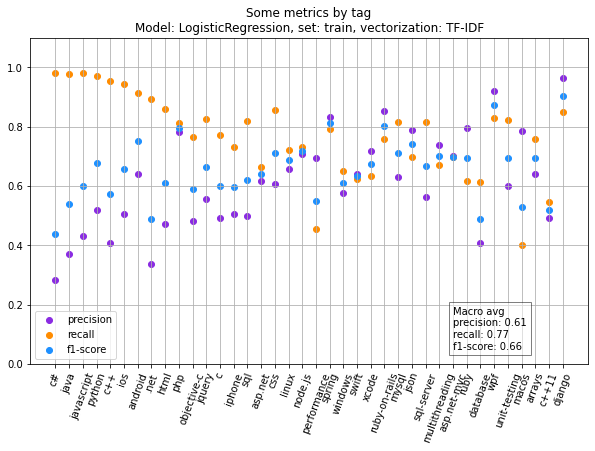

In [13]:
diplay_and_plot_report(y_train, y_pred_train, 'LogisticRegression', 'train', 'TF-IDF')

Classifier: LogisticRegression	Dataset: test
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       0.25      0.96      0.40       467
          java       0.32      0.93      0.48       430
    javascript       0.42      0.92      0.58       409
        python       0.45      0.93      0.60       354
           c++       0.34      0.86      0.49       293
           ios       0.46      0.86      0.60       285
       android       0.57      0.80      0.67       249
          .net       0.25      0.67      0.37       239
          html       0.47      0.70      0.57       206
           php       0.73      0.63      0.67       164
   objective-c       0.30      0.48      0.37       147
        jquery       0.53      0.75      0.62       150
             c       0.33      0.52      0.40       131
        iphone       0.40      0.59      0.47       134
           sql       0.49      0.72      0.

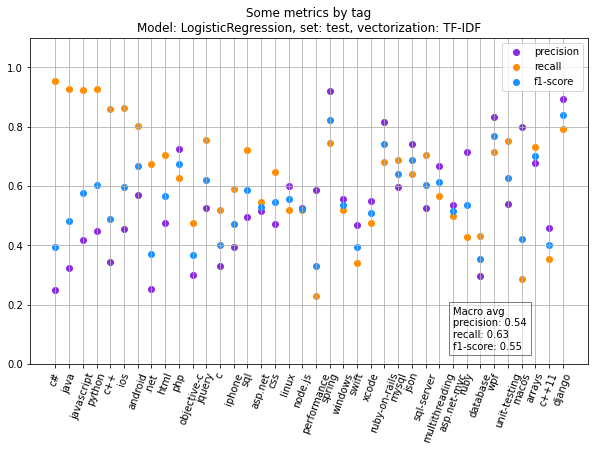

In [14]:
diplay_and_plot_report(y_test, y_pred_test, 'LogisticRegression', 'test','TF-IDF')

In [15]:
fpr, tpr, roc_auc = compute_roc_data(y_train,y_pred_train_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.97
Macro-averaged One-vs-Rest ROC AUC score:
0.98


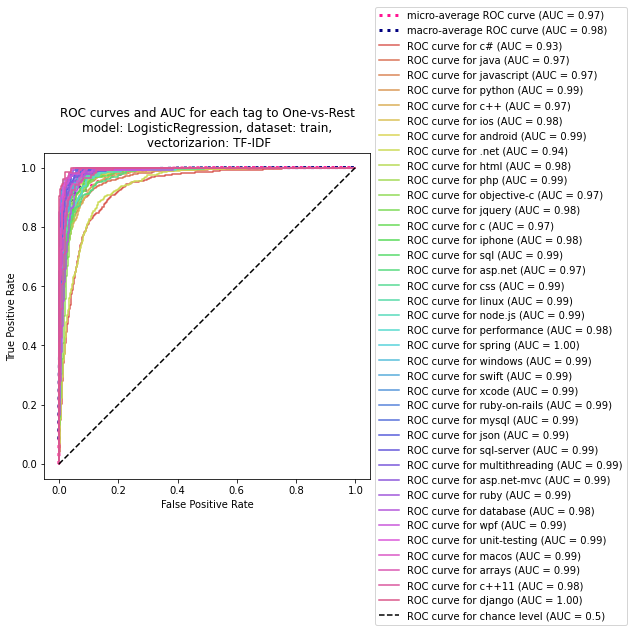

In [16]:
plot_roc_curves(
    fpr,tpr,roc_auc,'LogisticRegression', 'train', 'TF-IDF',y_train, y_pred_train_proba)

In [17]:
fpr, tpr, roc_auc = compute_roc_data(y_test,y_pred_test_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.94
Macro-averaged One-vs-Rest ROC AUC score:
0.95


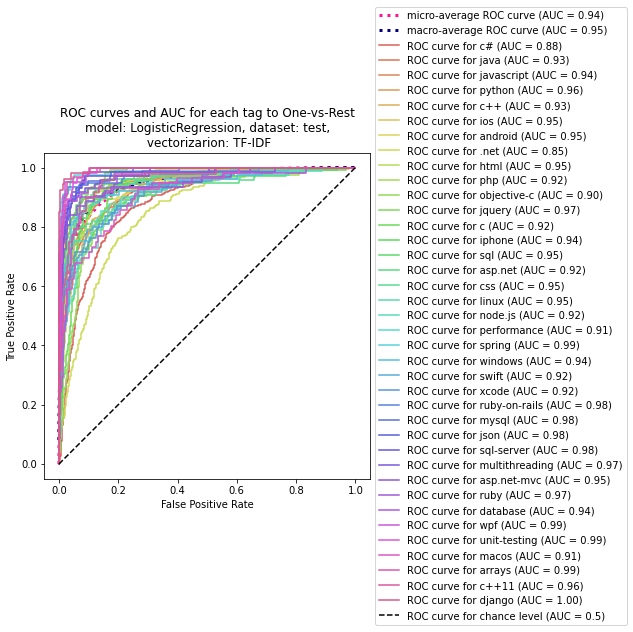

In [18]:
plot_roc_curves(
    fpr,tpr,roc_auc,'LogisticRegression', 'test', 'TF-IDF',y_test, y_pred_test_proba)

In [19]:
# Appending results for later compare
append_results(vectorization='TF-IDF',
               model='LogisticRegression', 
               f1=f1_sco, 
               auc=roc_auc_res,
               fittime=fittime)

In [20]:
classification_results

{'Vectorization': ['TF-IDF'],
 'Model': ['LogisticRegression'],
 'Macro. avg. f1-score': [0.55],
 'Macro. avg. AUC': [0.95],
 'Fit time': [3.87]}

### Naive-Bayes classifier (TD-IDF)

In [21]:
parameters = {
    'estimator__alpha' : [0.05, 0.2, 0.5, 1],
    'estimator__fit_prior' : [True, False]
}

# Instantiating OneVsRest Classifier
cl = OneVsRestClassifier(MultinomialNB())

# Grid search for best hyperparameters
grid_search = GridSearchCV(
    estimator = cl,
    param_grid= parameters,
    scoring='roc_auc_ovr',
    verbose=2,
    n_jobs=-1
)

# Performing grid search
grid_search.fit(X_train, y_train)

# Instantiating Best OneVsRest Classifier
cl = grid_search.best_estimator_

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
fittime = finish - start
print(f'fit time: {fittime} secs.')

# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

# Print best parameters
print('The best parameters are:')
print(grid_search.best_params_)
print('The best score is:')
print(grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
fit time: 0.19145822525024414 secs.
predict time: 0.12760448455810547 secs.
The best parameters are:
{'estimator__alpha': 0.05, 'estimator__fit_prior': True}
The best score is:
0.9309356232114998


In [22]:
# Choosing best threshold for classification
thresh = choose_best_thres(y_train, y_pred_train_proba)

# predictions based on threshold
y_pred_train = (y_pred_train_proba > thresh).astype(int)
y_pred_test = (y_pred_test_proba > thresh).astype(int)

Threshold that maximizes f1-score: 0.2


#### Evaluation: NaiveBayes

Classifier: MultinomialNB	Dataset: train
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       0.63      0.82      0.71      1012
          java       0.74      0.79      0.76       901
    javascript       0.67      0.86      0.75       769
        python       0.78      0.86      0.82       747
           c++       0.64      0.81      0.71       600
           ios       0.68      0.81      0.74       564
       android       0.77      0.85      0.81       507
          .net       0.61      0.61      0.61       526
          html       0.60      0.76      0.67       333
           php       0.89      0.72      0.79       313
   objective-c       0.59      0.66      0.63       292
        jquery       0.62      0.78      0.69       288
             c       0.67      0.73      0.70       240
        iphone       0.59      0.71      0.64       257
           sql       0.66      0.87      0.75  

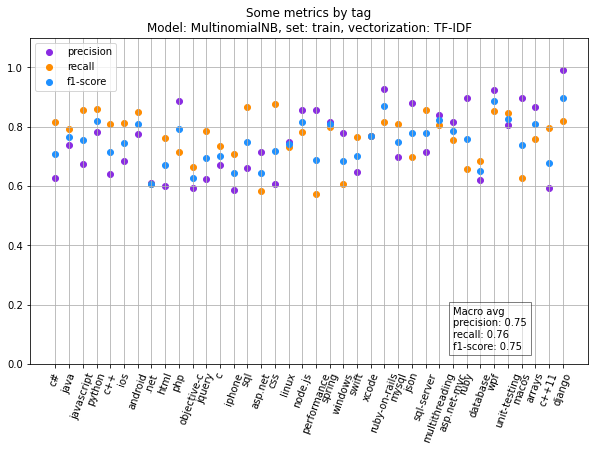

In [23]:
diplay_and_plot_report(y_train, y_pred_train, 'MultinomialNB', 'train', 'TF-IDF')

Classifier: MultinomialNB	Dataset: test
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       0.55      0.67      0.61       467
          java       0.65      0.68      0.67       430
    javascript       0.62      0.69      0.65       409
        python       0.67      0.67      0.67       354
           c++       0.54      0.67      0.60       293
           ios       0.62      0.67      0.64       285
       android       0.66      0.64      0.65       249
          .net       0.37      0.25      0.30       239
          html       0.45      0.44      0.44       206
           php       0.77      0.35      0.48       164
   objective-c       0.39      0.37      0.38       147
        jquery       0.52      0.57      0.55       150
             c       0.39      0.30      0.34       131
        iphone       0.43      0.46      0.44       134
           sql       0.62      0.55      0.58   

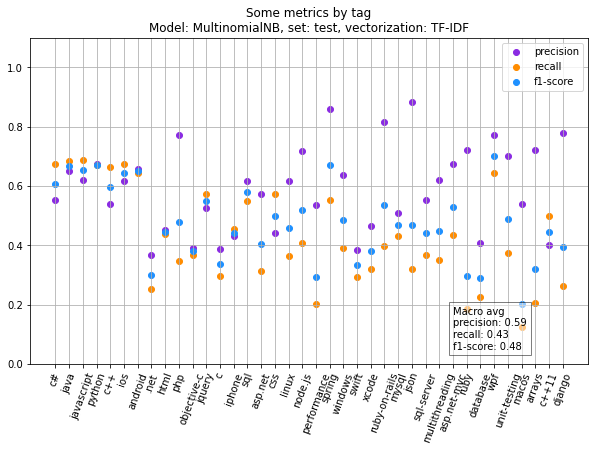

In [24]:
diplay_and_plot_report(y_test, y_pred_test, 'MultinomialNB', 'test', 'TF-IDF')

In [25]:
fpr, tpr, roc_auc = compute_roc_data(y_train,y_pred_train_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.99
Macro-averaged One-vs-Rest ROC AUC score:
0.99


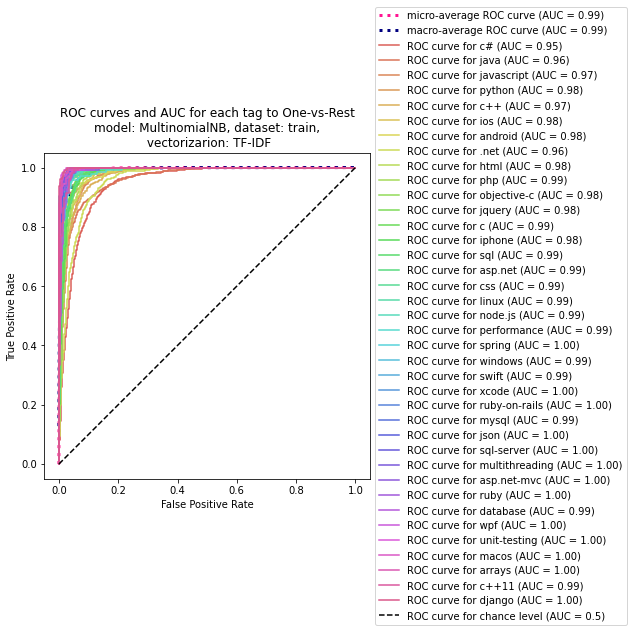

In [26]:
plot_roc_curves(
    fpr,tpr,roc_auc,'MultinomialNB', 'train','TF-IDF',y_train, y_pred_train_proba)

In [27]:
fpr, tpr, roc_auc = compute_roc_data(y_test,y_pred_test_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.94
Macro-averaged One-vs-Rest ROC AUC score:
0.93


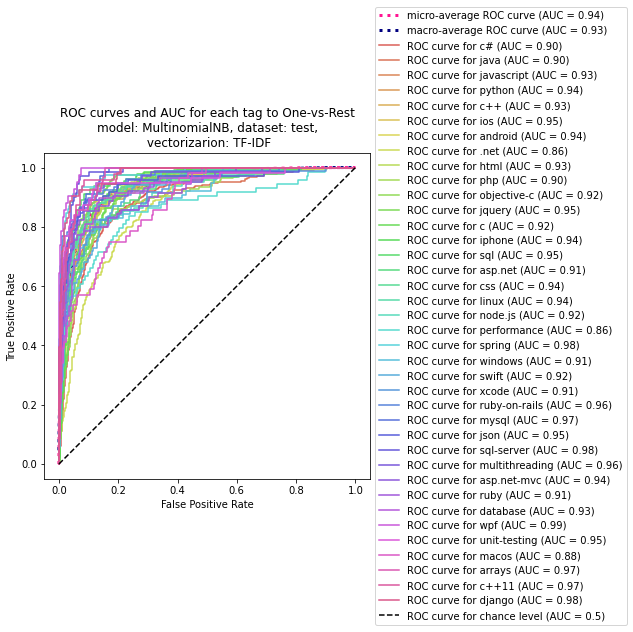

In [28]:
plot_roc_curves(
    fpr,tpr,roc_auc,'MultinomialNB', 'test','TF-IDF',y_test, y_pred_test_proba)

In [29]:
# Appending results for later compare
append_results(vectorization='TF-IDF',
               model='MultinomialNB', 
               f1=f1_sco, 
               auc=roc_auc_res,
               fittime=fittime)

In [30]:
classification_results

{'Vectorization': ['TF-IDF', 'TF-IDF'],
 'Model': ['LogisticRegression', 'MultinomialNB'],
 'Macro. avg. f1-score': [0.55, 0.48],
 'Macro. avg. AUC': [0.95, 0.93],
 'Fit time': [3.87, 3.87]}

### RandomForestClassifier

We tried to fine tune this random forest classifier, but it took so long. One strategy is to execute this random search on google collab. For the moment we leave the search as a commented cell and we use the default hyperparameters to compare.

In [ ]:
# # Hyperparameter tuning for RandomForest

# parameters = {
#     'estimator__n_estimators' : [50, 100, 150, 200, 250],
#     'estimator__max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
#     'estimator__min_samples_split' : [2,5,10],
#     'estimator__min_samples_leaf' : [1,2,4],
#     'estimator__bootstrap' : [True, False],
#     'estimator__max_features' : ['sqrt', 'log2', None]
# }

# # Instantiating OneVsRest Classifier
# cl = OneVsRestClassifier(RandomForestClassifier())

# # Random search for best hyperparameters
# random_search = RandomizedSearchCV(
#     estimator = cl,
#     param_distributions= parameters,
#     n_iter=30,
#     scoring='roc_auc_ovr',
#     verbose=2,
#     random_state=5,
#     n_jobs=-1
# )

# # Perform random search
# random_search.fit(X_train, y_train)

# # Instantiating OneVsRest Classifier default parameters
# cl = random_search.best_estimator_

# # Fitting classifier
# start = time.time()
# cl.fit(X_train,y_train)
# finish = time.time()
# fittime = finish - start
# print(f'fit time: {fittime} secs.')

# # Predicting (with probabilites)
# start = time.time()
# y_pred_train_proba = cl.predict_proba(X_train)
# finish = time.time()
# print(f'predict time: {finish - start} secs.')

# y_pred_test_proba = cl.predict_proba(X_test)

# # Print best parameters
# print('The best parameters are:')
# print(random_search.best_params_)
# print('The best score is:')
# print(random_search.best_score_)


In [32]:
# Instantiating OneVsRest Classifier DEFAULT parameters
cl = OneVsRestClassifier(RandomForestClassifier())

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
fittime = finish - start
print(f'fit time: {fittime} secs.')

# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

fit time: 86.42486476898193 secs.
predict time: 7.547614097595215 secs.


In [33]:
# choose threshold for maximal f1-score
thresh = choose_best_thres(y_train, y_pred_train_proba)

# predictions based on threshold
y_pred_train = (y_pred_train_proba > thresh).astype(int)
y_pred_test = (y_pred_test_proba > thresh).astype(int)

Threshold that maximizes f1-score: 0.4


#### Evaluation: RandomForestClassifier

Classifier: RandomForestClassifier	Dataset: train
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       1.00      1.00      1.00      1012
          java       1.00      1.00      1.00       901
    javascript       1.00      1.00      1.00       769
        python       1.00      1.00      1.00       747
           c++       1.00      1.00      1.00       600
           ios       1.00      1.00      1.00       564
       android       1.00      1.00      1.00       507
          .net       1.00      1.00      1.00       526
          html       1.00      1.00      1.00       333
           php       1.00      1.00      1.00       313
   objective-c       1.00      1.00      1.00       292
        jquery       1.00      1.00      1.00       288
             c       1.00      1.00      1.00       240
        iphone       1.00      1.00      1.00       257
           sql       1.00      1.00   

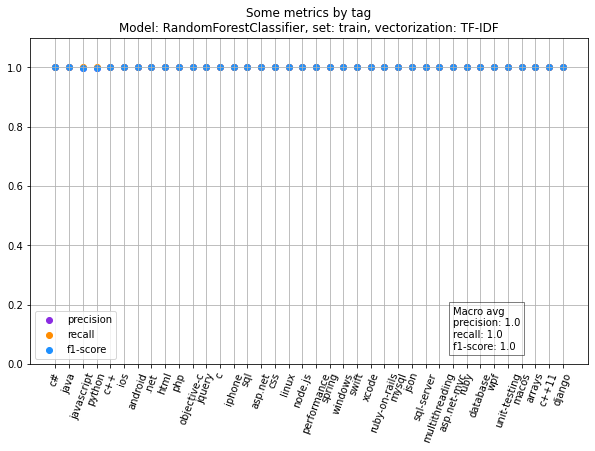

In [34]:
diplay_and_plot_report(y_train, y_pred_train, 'RandomForestClassifier', 'train', 'TF-IDF')

Classifier: RandomForestClassifier	Dataset: test
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       0.58      0.32      0.41       467
          java       0.81      0.70      0.75       430
    javascript       0.72      0.63      0.67       409
        python       0.88      0.79      0.83       354
           c++       0.79      0.41      0.54       293
           ios       0.72      0.67      0.70       285
       android       0.86      0.70      0.77       249
          .net       0.36      0.05      0.09       239
          html       0.68      0.13      0.22       206
           php       0.84      0.64      0.73       164
   objective-c       0.56      0.10      0.17       147
        jquery       0.80      0.47      0.59       150
             c       1.00      0.02      0.03       131
        iphone       0.68      0.32      0.44       134
           sql       0.78      0.13    

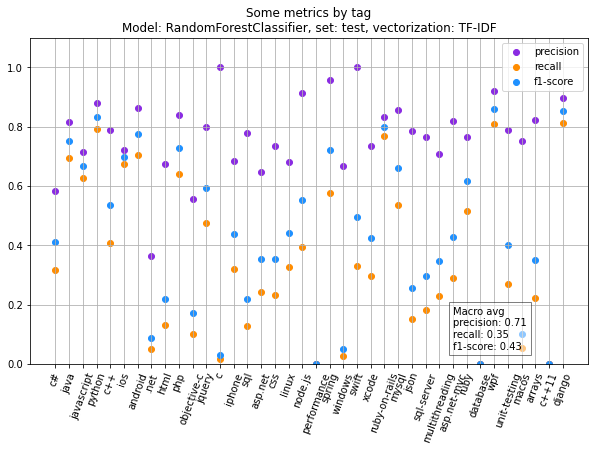

In [35]:
diplay_and_plot_report(y_test, y_pred_test, 'RandomForestClassifier', 'test', 'TF-IDF')

In [36]:
fpr, tpr, roc_auc = compute_roc_data(y_train,y_pred_train_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
1.00
Macro-averaged One-vs-Rest ROC AUC score:
1.00


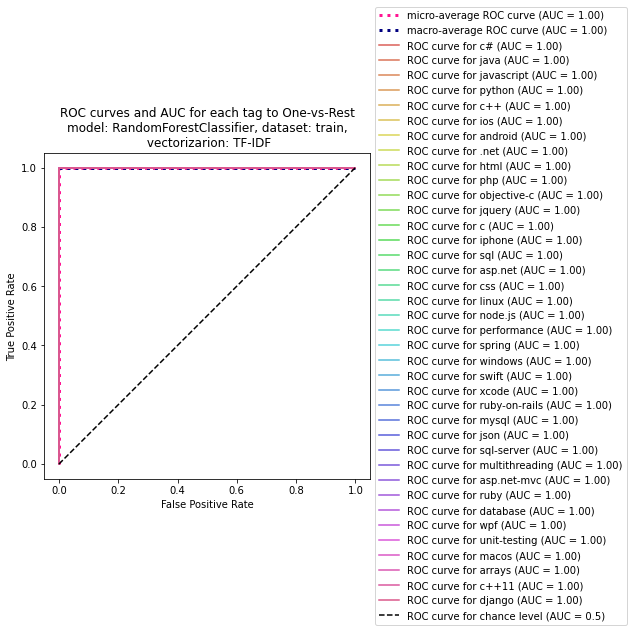

In [37]:
plot_roc_curves(
    fpr,tpr,roc_auc,'RandomForestClassifier', 'train','TF-IDF',y_train, y_pred_train_proba)

In [38]:
fpr, tpr, roc_auc = compute_roc_data(y_test,y_pred_test_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.94
Macro-averaged One-vs-Rest ROC AUC score:
0.92


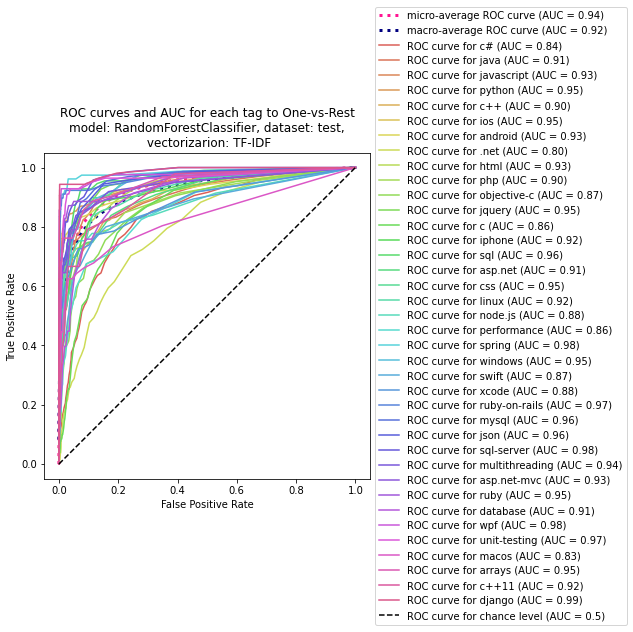

In [39]:
plot_roc_curves(
    fpr,tpr,roc_auc,'RandomForestClassifier', 'test','TF-IDF',y_test, y_pred_test_proba)

In [40]:
# Appending results for later compare
append_results(vectorization='TF-IDF',
               model='RandomForestCl', 
               f1=f1_sco, 
               auc=roc_auc_res,
               fittime=fittime)

In [42]:
classification_results

{'Vectorization': ['TF-IDF', 'TF-IDF', 'TF-IDF'],
 'Model': ['LogisticRegression', 'MultinomialNB', 'RandomForestCl'],
 'Macro. avg. f1-score': [0.55, 0.48, 0.43],
 'Macro. avg. AUC': [0.95, 0.93, 0.92],
 'Fit time': [3.87, 3.87, 86.42]}

# Word2vec (Supervised)

The steps of this part of the processing + modeling + classification are:

* We create and train a Word2Vec model with our sentences/processed text. This model provides a **vocabulary**.
  
* From this **vocabulary** and with [**tensorflow.keras.preprocessing.text.Tokenizer**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) we create an **index** for our vocabulary and turn each of our sentences into a padded **sequence** of length 33 (the mean of the length of sentences) assigning each word on the sentence to their index.

* We then create an **Embedding matrix** where each row corresponds to a word of our vocabulary and is a vector of dimension 300 provided by our Word2Vec trained model.

* Then we create a tensorflow.keras model with an [**Embedding layer**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) and our embedding matrix as weights. This model uses [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) to make an average of the embeddings.

* Finally we use the embedding model to predict in our sentences/processed text and this gives us a feature matrix, ready to be splitted in train/test sets and we perform different classifications models.

In [41]:
# Calulating some statistics for the length (in # of words) of our sentences
df.processed_text.apply(lambda x:len(x.split())).describe()

count    10000.000000
mean        47.388300
std         32.819547
min          3.000000
25%         25.000000
50%         39.000000
75%         59.000000
max        292.000000
Name: processed_text, dtype: float64

The mean is 32 words per sentence, we choose this value as `maxlen`.

Creation and training of the Word2Vec model:

In [43]:
import gensim

In [43]:
# Build & train Word2Vec model
print("Build & train Word2Vec model ...")

# Word2Vec model parameters
w2v_size=300
w2v_window=5
w2v_min_count=20
w2v_epochs=100 
maxlen = 32 
sentences = df['processed_text'].to_list()
sentences = [text.split() for text in sentences]

# Instantiate model
# w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, 
#                                    vector_size=w2v_size,
#                                    window=w2v_window,
#                                    # max_final_vocab=2000,
#                                    workers=1)

# Instantiate model
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, 
                                   vector_size=w2v_size,
                                   window=w2v_window,
                                   # max_final_vocab=2000,
                                   workers=1)

# Building vocabulary
w2v_model.build_vocab(sentences)

# Training the model
w2v_model.train(sentences, 
                total_examples=w2v_model.corpus_count, # Since = sentences to build
                epochs=w2v_epochs)

# Model vectors (words <--> embeddings)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key

print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

# Save/load model
# model_vectors.save('word2vecV1.wordvectors')  # Store
# model_vectors = KeyedVectors.load('word2vecV1.wordvectors', mmap='r')  # Load

# If older gensim version
# w2v_words = list(model_vectors.vocab.keys())

Build & train Word2Vec model ...
Vocabulary size: 2134
Word2Vec trained


In [45]:
# Display some words of our vocabulary
print(f'The first 10 words of our vocabulary are:\n {w2v_words[:10]}')

The first 10 words of our vocabulary are:
 ['code', 'work', 'use', 'try', 'file', 'want', 'way', 'error', 'need', 'run']


In [46]:
# Inserting a non-word
w2v_words.insert(0,'')
w2v_words[:10]

['', 'code', 'work', 'use', 'try', 'file', 'want', 'way', 'error', 'need']

In [47]:
# display the first 10 coordinates of the word python in our vocab.
print(f"Example: The first 10 coordinates of the vector associated to the word python:\n {model_vectors['python'][:10]}")

Example: The first 10 coordinates of the vector associated to the word python:
 [ 0.39939713 -0.40650746 -0.98120797  1.4155328   0.20339684 -0.30614898
  0.13168153  0.05809788 -0.49654502  0.45783257]


In [48]:
# Display the most similar words to 'python'
print('The most similar words to python are:')
w2v_model.wv.most_similar('python')

The most similar words to python are:


[('theory', 0.3638201951980591),
 ('refuse', 0.3528735935688019),
 ('experiment', 0.3369831442832947),
 ('criterion', 0.33543771505355835),
 ('winforms', 0.32776838541030884),
 ('replicate', 0.3250358998775482),
 ('template', 0.30194762349128723),
 ('fit', 0.30081450939178467),
 ('xib', 0.29964348673820496),
 ('tablet', 0.2917824387550354)]

We prepare the sentences from our processed text.

In [49]:
# Creation of index with our vocabulary
tokenizer = Tokenizer(filters='\t\n') # tensorflow.keras.preprocessing.text
# Updating internal vocabulary (create word index from our vocabulary)
tokenizer.fit_on_texts(w2v_words)

# Printing summary
print(f'# of words in our vocabulary: {len(w2v_words)}')
print(f'# of words in our tokenizer.word_index: {len(tokenizer.word_index)}')
print('First 5 words in our vocabulary:')
print(' ', w2v_words[:5])
print('First 5 words in tokenizer.word_index')
print(' ', list(tokenizer.word_index.items())[:5])


# of words in our vocabulary: 2135
# of words in our tokenizer.word_index: 2134
First 5 words in our vocabulary:
  ['', 'code', 'work', 'use', 'try']
First 5 words in tokenizer.word_index
  [('code', 1), ('work', 2), ('use', 3), ('try', 4), ('file', 5)]


In [50]:
# Transforming each sentence to a sequence (following tokenizer.word_index)
sequences = tokenizer.texts_to_sequences(sentences)

# Padding sequences so they all have the same length
x_sentences = pad_sequences(sequences,
                            maxlen=maxlen,
                            padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print(f'Number of unique words: {num_words}\n')

print('Example:')
print(f'The sentence {sentences[0]},')
print(f'Corresponding to {sequences[0]}')
print(f'becomes the sequence: {x_sentences[0]}')

Number of unique words: 2135

Example:
The sentence ['detect', 'notification', 'background', 'music', 'app', 'write', 'mpmusicplayercontroller.systemmusicplayer', 'try', 'applicationmusicplayer', 'music', 'play', 'background', 'expect', 'app', 'background', 'need', 'playback', 'state', 'change', 'notification', 'app', 'determine', 'song', 'play', 'following', 'viewdidload', 'method', 'method', 'playbackchange', 'call', 'state', 'application', 'foreground', 'app', 'background', 'remember', 'ios', 'deprecate', 'notification', 'background', 'idea', 'go'],
Corresponding to [315, 372, 221, 1857, 14, 37, 4, 1857, 254, 221, 138, 14, 221, 9, 1810, 243, 33, 372, 14, 447, 1946, 254, 252, 16, 16, 43, 243, 19, 14, 221, 1086, 183, 896, 372, 221, 86, 124]
becomes the sequence: [  37    4 1857  254  221  138   14  221    9 1810  243   33  372   14
  447 1946  254  252   16   16   43  243   19   14  221 1086  183  896
  372  221   86  124]


We now create the **embedding matrix** of our vocabulary

In [51]:
# Creation of the embedding matrix
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print(f'Embedding matrix size : {embedding_matrix.shape}')

Word embedding rate :  1.0
Embedding matrix size : (2135, 300)


We are now ready to create the **embedding model**

In [52]:
# Creation of model
input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')

# Creation of the embedding
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights=[embedding_matrix],
                         input_length=maxlen)(word_input)

word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 embedding (Embedding)       (None, 32, 300)           640500    
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 640,500
Trainable params: 640,500
Non-trainable params: 0
_________________________________________________________________


In [53]:
# Model execution: getting the embeddings for our documents
embeddings = embed_model.predict(x_sentences)
print(f'The embedding shape of our documents is: {embeddings.shape}')

313/313 [==============================] - 1s 1ms/step
The embedding shape of our documents is: (10000, 300)


We can now obtain our **feature matrix**:

In [54]:
X = embeddings

# Defining target vector
columns_tags = ['tag_'+tag for tag in tag_list]
y = df[columns_tags]

# Splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.33, random_state=5
)

## Classification

### Logistic Regression

In [65]:
# Hyperparameters for logistic regression
parameters = {
    'estimator__penalty' : ['l1', 'l2'],
    'estimator__tol' : [1e-6, 1e-5, 1e-4, 1e-3],
    'estimator__C' : [0.01,0.05 ,0.1, 0.5, 0.7, 1],
    'estimator__fit_intercept' : [True, False],
    'estimator__solver' : ['liblinear','sag', 'saga']
}

# Instantiating OneVsRest Classifier
cl = OneVsRestClassifier(LogisticRegression())

# Random search for best hyperparameters
random_search = RandomizedSearchCV(
    estimator = cl,
    param_distributions= parameters,
    n_iter=20,
    scoring='roc_auc_ovr',
    random_state=5,
    n_jobs=-1
)

# Perform random search
random_search.fit(X_train, y_train)

# Instantiating BEST OneVsRest Classifier
cl = random_search.best_estimator_

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
print(f'fit time: {finish - start} secs.')

# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

fit time: 20.48701810836792 secs.
predict time: 0.2104785442352295 secs.


In [66]:
# Print best parameters
print('The best parameters are:')
print(random_search.best_params_)
print('The best score is:')
print(random_search.best_score_)

The best parameters are:
{'estimator__tol': 0.0001, 'estimator__solver': 'sag', 'estimator__penalty': 'l2', 'estimator__fit_intercept': True, 'estimator__C': 0.05}
The best score is:
0.9245329376227254


In [55]:
# Instantiating OneVsRest Classifier with BEST parameters found
cl = OneVsRestClassifier(LogisticRegression(
    tol=0.0001,
    solver='sag',
    penalty='l2',
    fit_intercept=True,
    C=0.05
))

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
fittime = finish - start
print(f'fit time: {fittime} secs.')

# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

fit time: 25.07970404624939 secs.
predict time: 0.10018086433410645 secs.


In [56]:
thresh = choose_best_thres(y_train, y_pred_train_proba)

# Predictions based on threshold
y_pred_train = (y_pred_train_proba > thresh).astype(int)
y_pred_test = (y_pred_test_proba > thresh).astype(int)

Threshold that maximizes f1-score: 0.2


#### Evaluation: LogisticRegression

Classifier: LogisticRegression	Dataset: train
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       0.49      0.74      0.59      1012
          java       0.58      0.73      0.65       901
    javascript       0.56      0.75      0.64       769
        python       0.67      0.76      0.71       747
           c++       0.61      0.76      0.68       600
           ios       0.63      0.71      0.67       564
       android       0.71      0.72      0.71       507
          .net       0.42      0.46      0.44       526
          html       0.51      0.62      0.56       333
           php       0.62      0.50      0.55       313
   objective-c       0.43      0.39      0.41       292
        jquery       0.51      0.55      0.53       288
             c       0.52      0.58      0.55       240
        iphone       0.43      0.38      0.40       257
           sql       0.51      0.60      0

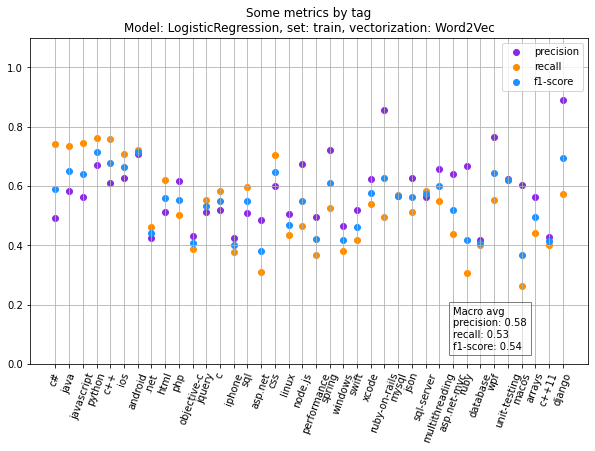

In [57]:
diplay_and_plot_report(y_train, y_pred_train, 'LogisticRegression', 'train', 'Word2Vec')

Classifier: LogisticRegression	Dataset: test
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       0.46      0.69      0.56       467
          java       0.50      0.66      0.57       430
    javascript       0.55      0.71      0.62       409
        python       0.59      0.70      0.64       354
           c++       0.57      0.71      0.63       293
           ios       0.57      0.65      0.60       285
       android       0.62      0.65      0.64       249
          .net       0.35      0.36      0.35       239
          html       0.47      0.50      0.48       206
           php       0.60      0.39      0.47       164
   objective-c       0.29      0.29      0.29       147
        jquery       0.51      0.59      0.55       150
             c       0.39      0.44      0.42       131
        iphone       0.37      0.39      0.38       134
           sql       0.55      0.51      0.

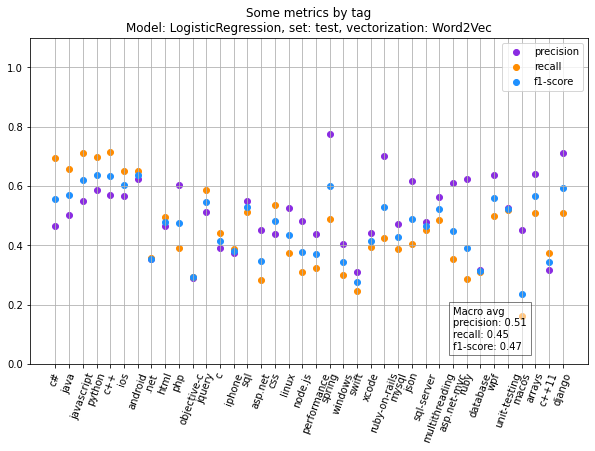

In [58]:
diplay_and_plot_report(y_test, y_pred_test, 'LogisticRegression', 'test','Word2Vec')

In [59]:
fpr, tpr, roc_auc = compute_roc_data(y_train,y_pred_train_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.95
Macro-averaged One-vs-Rest ROC AUC score:
0.95


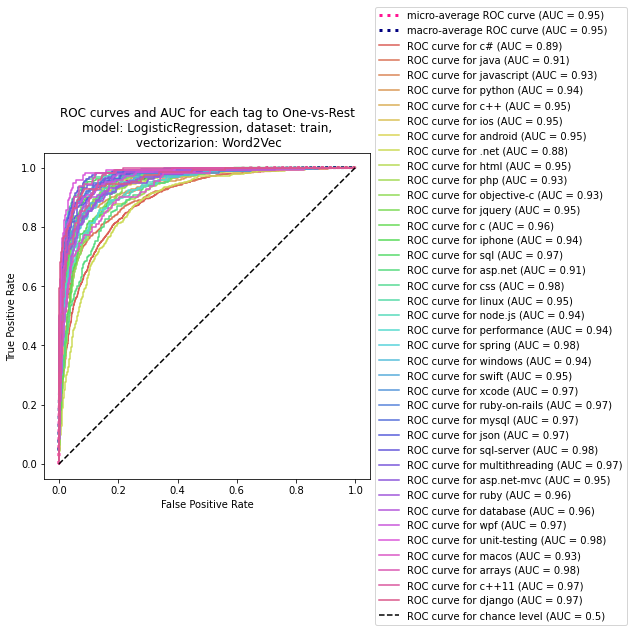

In [60]:
plot_roc_curves(
    fpr,tpr,roc_auc,'LogisticRegression', 'train','Word2Vec',y_train, y_pred_train_proba)

In [61]:
fpr, tpr, roc_auc = compute_roc_data(y_test,y_pred_test_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.93
Macro-averaged One-vs-Rest ROC AUC score:
0.92


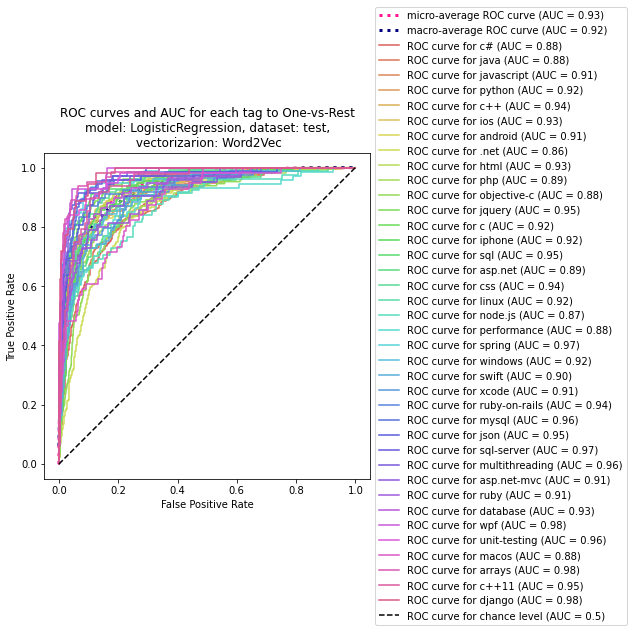

In [62]:
plot_roc_curves(
    fpr,tpr,roc_auc,'LogisticRegression', 'test','Word2Vec',y_test, y_pred_test_proba)

In [63]:
# Appending results for later compare
append_results(vectorization='Word2Vec',
               model='LogisticRegression', 
               f1=f1_sco, 
               auc=roc_auc_res,
               fittime=fittime)

In [64]:
classification_results

{'Vectorization': ['TF-IDF', 'TF-IDF', 'TF-IDF', 'Word2Vec'],
 'Model': ['LogisticRegression',
  'MultinomialNB',
  'RandomForestCl',
  'LogisticRegression'],
 'Macro. avg. f1-score': [0.55, 0.48, 0.43, 0.47],
 'Macro. avg. AUC': [0.95, 0.93, 0.92, 0.92],
 'Fit time': [3.87, 3.87, 86.42, 25.08]}

### RandomForest


In [65]:
# Instantiating OneVsRest Classifier default parameters
cl = OneVsRestClassifier(RandomForestClassifier())

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
fittime = finish - start
print(f'fit time: {fittime} secs.')

# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

fit time: 401.7576072216034 secs.
predict time: 3.575918674468994 secs.


In [66]:
# choose threshold for maximal f1-score
thresh = choose_best_thres(y_train, y_pred_train_proba)

# predictions based on threshold
y_pred_train = (y_pred_train_proba > thresh).astype(int)
y_pred_test = (y_pred_test_proba > thresh).astype(int)

Threshold that maximizes f1-score: 0.4


#### Evaluation: RandomForestClassifier

Classifier: RandomForestClassifier	Dataset: train
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       1.00      1.00      1.00      1012
          java       1.00      1.00      1.00       901
    javascript       1.00      1.00      1.00       769
        python       1.00      1.00      1.00       747
           c++       1.00      1.00      1.00       600
           ios       1.00      1.00      1.00       564
       android       1.00      1.00      1.00       507
          .net       1.00      1.00      1.00       526
          html       1.00      1.00      1.00       333
           php       1.00      1.00      1.00       313
   objective-c       1.00      1.00      1.00       292
        jquery       1.00      1.00      1.00       288
             c       1.00      1.00      1.00       240
        iphone       1.00      1.00      1.00       257
           sql       1.00      1.00   

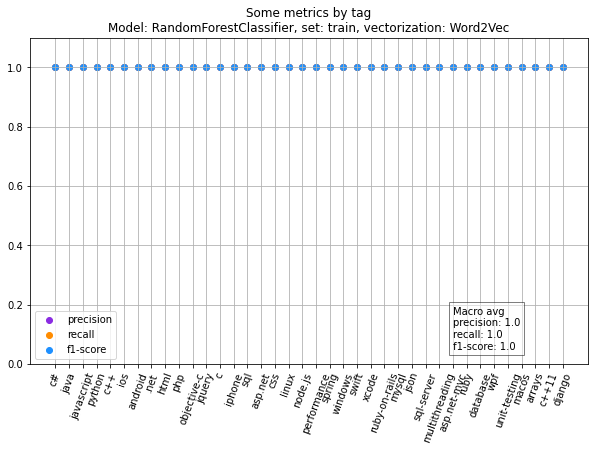

In [67]:
diplay_and_plot_report(y_train, y_pred_train, 'RandomForestClassifier', 'train','Word2Vec')

Classifier: RandomForestClassifier	Dataset: test
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       0.66      0.14      0.23       467
          java       0.70      0.15      0.25       430
    javascript       0.69      0.21      0.32       409
        python       0.80      0.22      0.35       354
           c++       0.71      0.33      0.45       293
           ios       0.72      0.25      0.37       285
       android       0.85      0.18      0.30       249
          .net       0.50      0.03      0.06       239
          html       0.55      0.11      0.18       206
           php       1.00      0.02      0.04       164
   objective-c       0.46      0.04      0.07       147
        jquery       0.64      0.09      0.16       150
             c       0.67      0.09      0.16       131
        iphone       0.29      0.03      0.05       134
           sql       0.72      0.16    

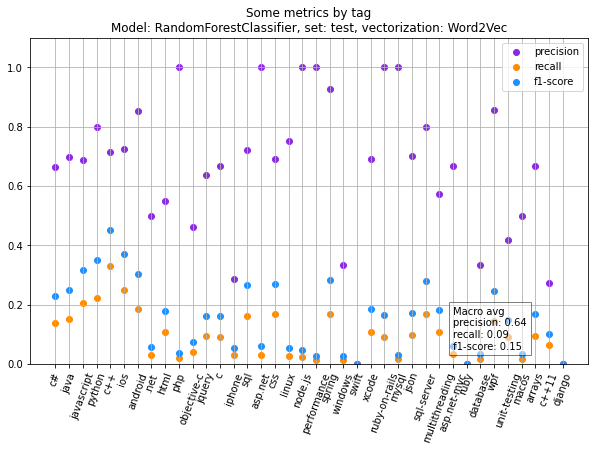

In [68]:
diplay_and_plot_report(y_test, y_pred_test, 'RandomForestClassifier', 'test','Word2Vec')

In [69]:
fpr, tpr, roc_auc = compute_roc_data(y_train,y_pred_train_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
1.00
Macro-averaged One-vs-Rest ROC AUC score:
1.00


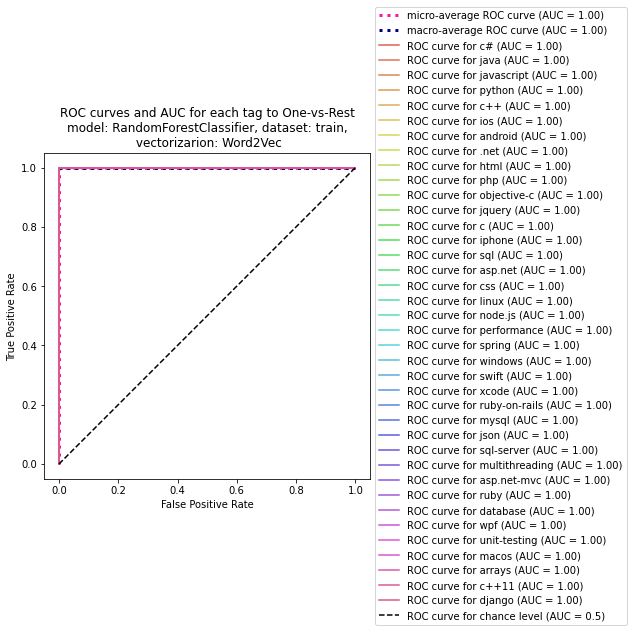

In [70]:
plot_roc_curves(
    fpr,tpr,roc_auc,'RandomForestClassifier', 'train','Word2Vec',y_train, y_pred_train_proba)

In [71]:
fpr, tpr, roc_auc = compute_roc_data(y_test,y_pred_test_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.86
Macro-averaged One-vs-Rest ROC AUC score:
0.82


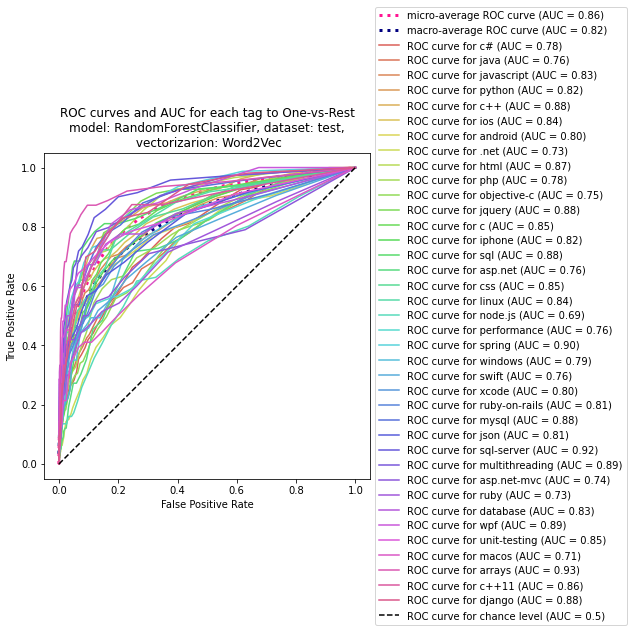

In [72]:
plot_roc_curves(
    fpr,tpr,roc_auc,'RandomForestClassifier', 'test','Word2Vec',y_test, y_pred_test_proba)

In [73]:
# Appending results for later compare
append_results(vectorization='Word2Vec',
               model='RandomForest', 
               f1=f1_sco, 
               auc=roc_auc_res,
               fittime=fittime)

### Naive-Bayes classifier (TD-IDF)

This classifier does not take negative numbers as an argument for the feature matrix. We then scale the data with min-max scaler to have them between 0 and 1.

In [74]:
from sklearn.preprocessing import MinMaxScaler

X = embeddings

# Scaling data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Defining target vector
columns_tags = ['tag_'+tag for tag in tag_list]
y = df[columns_tags]

# Splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,y, test_size=0.33, random_state=5
)

We do a random search for the best hyper-parameters

In [75]:
parameters = {
    'estimator__alpha' : [0.05, 0.2, 0.5, 1],
    'estimator__fit_prior' : [True, False]
}

# Instantiating OneVsRest Classifier
cl = OneVsRestClassifier(MultinomialNB())

# Grid search for best hyperparameters
grid_search = GridSearchCV(
    estimator = cl,
    param_grid= parameters,
    scoring='roc_auc_ovr',
    verbose=2,
    n_jobs=-1
)

# Performing grid search
grid_search.fit(X_train, y_train)

# Instantiating Best OneVsRest Classifier
cl = grid_search.best_estimator_

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
print(f'fit time: {finish - start} secs.')

# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

# Print best parameters
print('The best parameters are:')
print(grid_search.best_params_)
print('The best score is:')
print(grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
fit time: 0.3364543914794922 secs.
predict time: 0.3560776710510254 secs.
The best parameters are:
{'estimator__alpha': 0.05, 'estimator__fit_prior': True}
The best score is:
0.8790127550560582


In [76]:
# Choosing best threshold for classification
thresh = choose_best_thres(y_train, y_pred_train_proba)

# predictions based on threshold
y_pred_train = (y_pred_train_proba > thresh).astype(int)
y_pred_test = (y_pred_test_proba > thresh).astype(int)

Threshold that maximizes f1-score: 0.1


#### Evaluation: NaiveBayes

Classifier: MultinomialNB	Dataset: train
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       0.16      1.00      0.27      1012
          java       0.15      0.96      0.26       901
    javascript       0.26      0.82      0.39       769
        python       0.22      0.88      0.35       747
           c++       0.38      0.72      0.50       600
           ios       0.34      0.60      0.44       564
       android       0.36      0.53      0.43       507
          .net       0.29      0.26      0.27       526
          html       0.38      0.46      0.42       333
           php       0.38      0.03      0.05       313
   objective-c       0.30      0.16      0.21       292
        jquery       0.33      0.28      0.30       288
             c       0.43      0.21      0.28       240
        iphone       0.30      0.18      0.22       257
           sql       0.45      0.33      0.38  

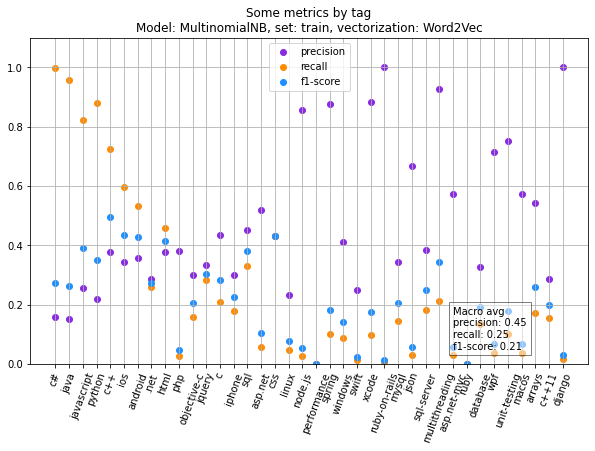

In [77]:
diplay_and_plot_report(y_train, y_pred_train, 'MultinomialNB', 'train','Word2Vec')

Classifier: MultinomialNB	Dataset: test
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       0.15      1.00      0.26       467
          java       0.15      0.97      0.26       430
    javascript       0.27      0.85      0.41       409
        python       0.21      0.86      0.33       354
           c++       0.38      0.74      0.50       293
           ios       0.35      0.59      0.44       285
       android       0.33      0.47      0.38       249
          .net       0.27      0.24      0.26       239
          html       0.40      0.39      0.39       206
           php       0.25      0.01      0.01       164
   objective-c       0.25      0.13      0.17       147
        jquery       0.40      0.32      0.35       150
             c       0.35      0.19      0.25       131
        iphone       0.29      0.17      0.22       134
           sql       0.48      0.26      0.34   

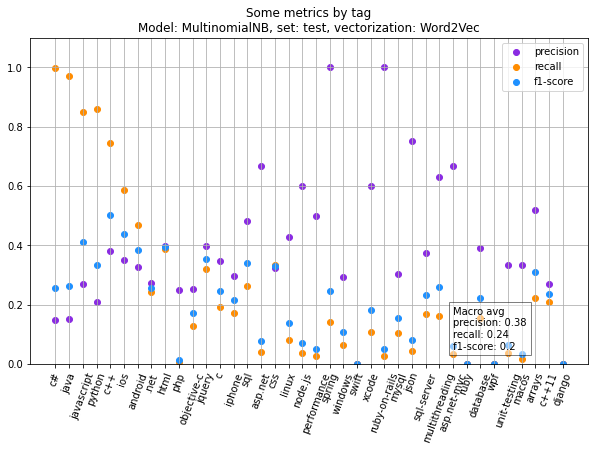

In [78]:
diplay_and_plot_report(y_test, y_pred_test, 'MultinomialNB', 'test','Word2Vec')

In [79]:
fpr, tpr, roc_auc = compute_roc_data(y_train,y_pred_train_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.86
Macro-averaged One-vs-Rest ROC AUC score:
0.89


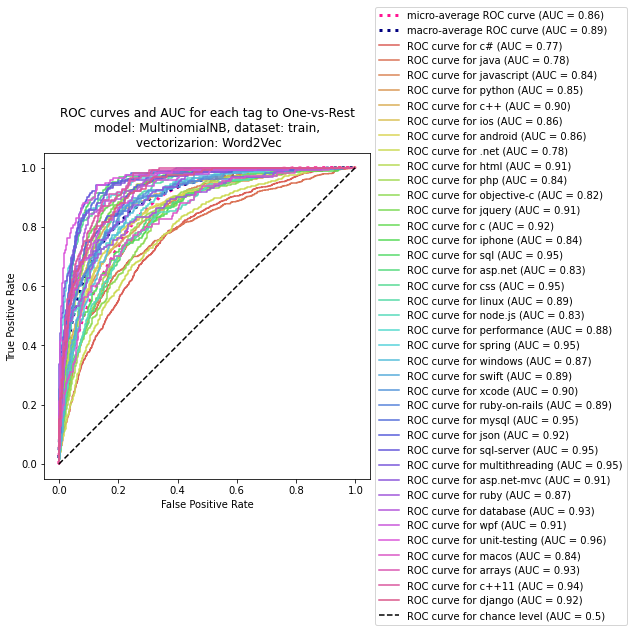

In [80]:
plot_roc_curves(
    fpr,tpr,roc_auc,'MultinomialNB', 'train','Word2Vec',y_train, y_pred_train_proba)

In [81]:
fpr, tpr, roc_auc = compute_roc_data(y_test,y_pred_test_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.86
Macro-averaged One-vs-Rest ROC AUC score:
0.88


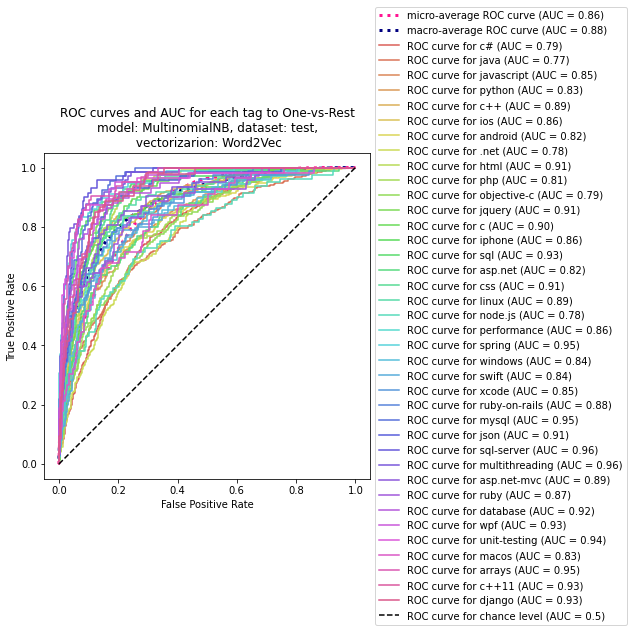

In [82]:
plot_roc_curves(
    fpr,tpr,roc_auc,'MultinomialNB', 'test','Word2Vec',y_test, y_pred_test_proba)

In [83]:
# Appending results for later compare
append_results(vectorization='Word2Vec',
               model='MultinomialNB', 
               f1=f1_sco, 
               auc=roc_auc_res,
               fittime=fittime)

# BERT (Supervised)

In [84]:
# Checking available GPU (colab)
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.11.0
2.11.0
Num GPUs Available:  1
True


## Preparation fonctions

In [85]:
# Function for preparing sentences

def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Feature creation function
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot # juste besoin du 1er

We now import and instantiate the BERT model.

In [86]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'

from transformers import AutoTokenizer, TFBertModel

model = TFBertModel.from_pretrained("bert-base-uncased")
sentences = df['processed_text'].to_list()

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



loading weights file tf_model.h5 from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tf_model.h5
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training

In [87]:
# Feature creation
features_bert, last_hidden_states_tot = feature_BERT_fct(model, 
                                                         model_type, 
                                                         sentences, 
                                                         max_length, 
                                                         batch_size, 
                                                         mode='HF')

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_ac

1/1 [==============================] - 0s 50ms/step
temps traitement :  704.0


In [88]:
np.save('features_bert.npy', features_bert) # save
# feats_bert = np.load('features_bert.npy')  # load 

We obtain our feature matrix:

In [89]:
X = features_bert

# Defining target vector
columns_tags = ['tag_'+tag for tag in tag_list]
y = df[columns_tags]

# Splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.33, random_state=5
)

## Classification

### Logistic regression

In [90]:
# # Hyperparameters for logistic regression
# parameters = {
#     'estimator__penalty' : ['l1', 'l2'],
#     'estimator__tol' : [1e-6, 1e-5, 1e-4, 1e-3],
#     'estimator__C' : [0.01,0.05 ,0.1, 0.5, 0.7, 1],
#     'estimator__fit_intercept' : [True, False],
#     'estimator__solver' : ['liblinear','sag', 'saga']
# }

# # Instantiating OneVsRest Classifier
# cl = OneVsRestClassifier(LogisticRegression())

# # Random search for best hyperparameters
# random_search = RandomizedSearchCV(
#     estimator = cl,
#     param_distributions= parameters,
#     n_iter=20,
#     scoring='roc_auc_ovr',
#     random_state=5,
#     n_jobs=-1
# )

# # Perform random search
# random_search.fit(X_train, y_train)

# # Instantiating BEST OneVsRest Classifier
# cl = random_search.best_estimator_

# # Fitting classifier
# start = time.time()
# cl.fit(X_train,y_train)
# finish = time.time()
# print(f'fit time: {finish - start} secs.')

# # Predicting (with probabilites)
# start = time.time()
# y_pred_train_proba = cl.predict_proba(X_train)
# finish = time.time()
# print(f'predict time: {finish - start} secs.')

# y_pred_test_proba = cl.predict_proba(X_test)

KeyboardInterrupt: ignored

In [ ]:
# Print best parameters
# print('The best parameters are:')
# print(random_search.best_params_)
# print('The best score is:')
# print(random_search.best_score_)

In [91]:
# Instantiating OneVsRest Classifier with best parameters found
cl = OneVsRestClassifier(LogisticRegression(
    tol=1e-05,
    solver='saga',
    penalty='l2',
    fit_intercept=True,
    C=0.7
))

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
fittime = finish - start
print(f'fit time: {fittime} secs.')

# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

fit time: 259.7124857902527 secs.
predict time: 0.23284649848937988 secs.


In [92]:
thresh = choose_best_thres(y_train, y_pred_train_proba)

# Predictions based on threshold
y_pred_train = (y_pred_train_proba > thresh).astype(int)
y_pred_test = (y_pred_test_proba > thresh).astype(int)

Threshold that maximizes f1-score: 0.2


#### Evaluation

Classifier: LogisticRegression	Dataset: train
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       0.48      0.78      0.60      1012
          java       0.52      0.75      0.61       901
    javascript       0.53      0.78      0.63       769
        python       0.60      0.83      0.70       747
           c++       0.65      0.81      0.72       600
           ios       0.58      0.78      0.66       564
       android       0.63      0.79      0.70       507
          .net       0.43      0.59      0.50       526
          html       0.56      0.72      0.63       333
           php       0.66      0.70      0.68       313
   objective-c       0.52      0.62      0.56       292
        jquery       0.67      0.71      0.69       288
             c       0.57      0.72      0.64       240
        iphone       0.54      0.65      0.59       257
           sql       0.60      0.77      0

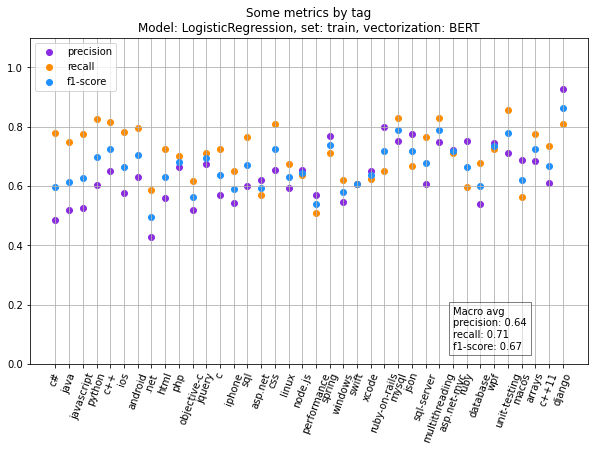

In [93]:
diplay_and_plot_report(y_train, 
                       y_pred_train, 
                       'LogisticRegression', 
                       'train',
                       'BERT')

Classifier: LogisticRegression	Dataset: test
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       0.41      0.70      0.52       467
          java       0.43      0.68      0.52       430
    javascript       0.48      0.66      0.56       409
        python       0.47      0.63      0.54       354
           c++       0.54      0.71      0.62       293
           ios       0.47      0.67      0.55       285
       android       0.51      0.67      0.58       249
          .net       0.28      0.33      0.30       239
          html       0.46      0.49      0.47       206
           php       0.50      0.53      0.51       164
   objective-c       0.30      0.39      0.34       147
        jquery       0.56      0.59      0.57       150
             c       0.40      0.48      0.44       131
        iphone       0.33      0.43      0.37       134
           sql       0.55      0.59      0.

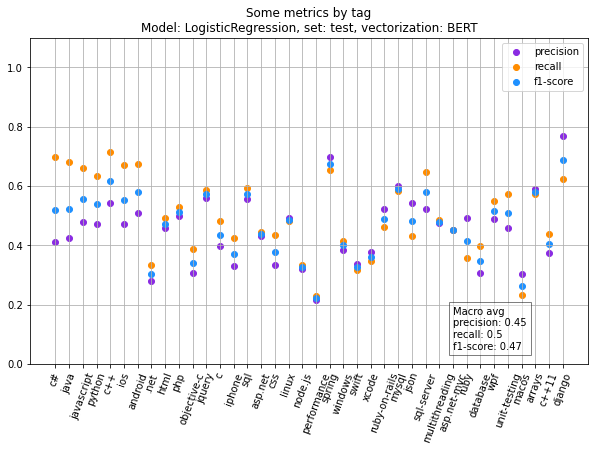

In [94]:
diplay_and_plot_report(y_test, 
                       y_pred_test, 
                       'LogisticRegression', 
                       'test',
                       'BERT')

In [95]:
fpr, tpr, roc_auc = compute_roc_data(y_train,
                                     y_pred_train_proba, 
                                     tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.97
Macro-averaged One-vs-Rest ROC AUC score:
0.97


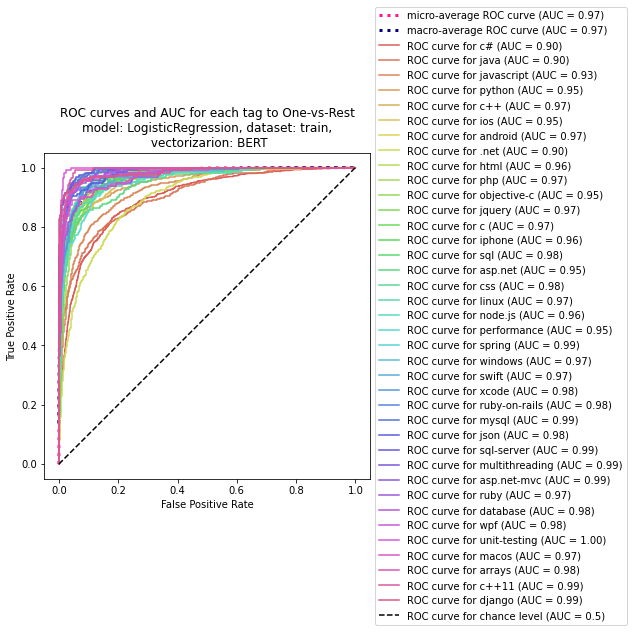

In [96]:
plot_roc_curves(fpr,
                tpr,
                roc_auc,
                'LogisticRegression', 
                'train',
                'BERT',
                y_train, 
                y_pred_train_proba)

In [97]:
fpr, tpr, roc_auc = compute_roc_data(y_test,
                                     y_pred_test_proba, 
                                     tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.92
Macro-averaged One-vs-Rest ROC AUC score:
0.90


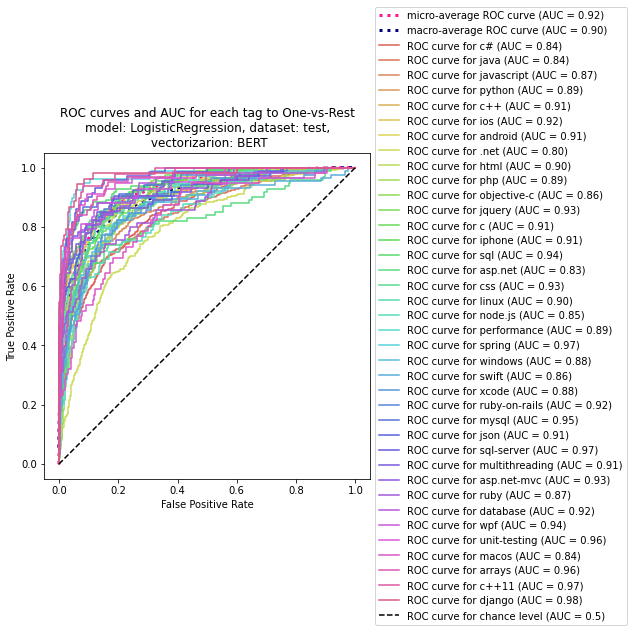

In [98]:
plot_roc_curves(fpr,
                tpr,
                roc_auc,
                'LogisticRegression', 
                'test',
                'BERT',
                y_test, 
                y_pred_test_proba)

In [99]:
# Appending results for later compare
append_results(vectorization='BERT',
               model='LogisticRegression', 
               f1=f1_sco, 
               auc=roc_auc_res,
               fittime=fittime)

### RandomForest classifier

In [101]:
# Instantiating OneVsRest Classifier default parameters
cl = OneVsRestClassifier(RandomForestClassifier())

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
fittime = finish - start
print(f'fit time: {fittime} secs.')

# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

fit time: 984.0557396411896 secs.
predict time: 5.608407735824585 secs.


In [102]:
# choose threshold for maximal f1-score
thresh = choose_best_thres(y_train, y_pred_train_proba)

# predictions based on threshold
y_pred_train = (y_pred_train_proba > thresh).astype(int)
y_pred_test = (y_pred_test_proba > thresh).astype(int)

Threshold that maximizes f1-score: 0.3


#### Evaluation: RandomForestCl

Classifier: RandomForestClassifier	Dataset: train
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       1.00      1.00      1.00      1012
          java       1.00      1.00      1.00       901
    javascript       1.00      1.00      1.00       769
        python       1.00      1.00      1.00       747
           c++       1.00      1.00      1.00       600
           ios       1.00      1.00      1.00       564
       android       1.00      1.00      1.00       507
          .net       1.00      1.00      1.00       526
          html       1.00      1.00      1.00       333
           php       1.00      1.00      1.00       313
   objective-c       1.00      1.00      1.00       292
        jquery       1.00      1.00      1.00       288
             c       1.00      1.00      1.00       240
        iphone       1.00      1.00      1.00       257
           sql       1.00      1.00   

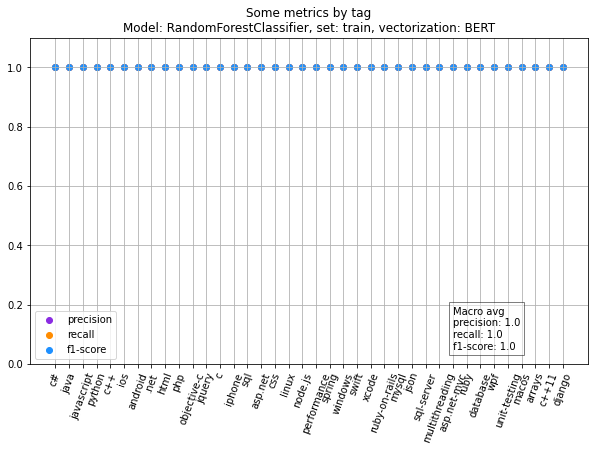

In [103]:
diplay_and_plot_report(y_train, 
                       y_pred_train, 
                       'RandomForestClassifier', 
                       'train',
                       'BERT')

Classifier: RandomForestClassifier	Dataset: test
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       0.32      0.21      0.25       467
          java       0.40      0.15      0.22       430
    javascript       0.38      0.10      0.15       409
        python       0.41      0.16      0.23       354
           c++       0.58      0.30      0.40       293
           ios       0.48      0.29      0.36       285
       android       0.44      0.27      0.33       249
          .net       0.33      0.08      0.12       239
          html       0.56      0.09      0.15       206
           php       0.14      0.01      0.02       164
   objective-c       0.30      0.06      0.10       147
        jquery       0.40      0.01      0.03       150
             c       0.29      0.04      0.07       131
        iphone       0.27      0.07      0.11       134
           sql       0.56      0.13    

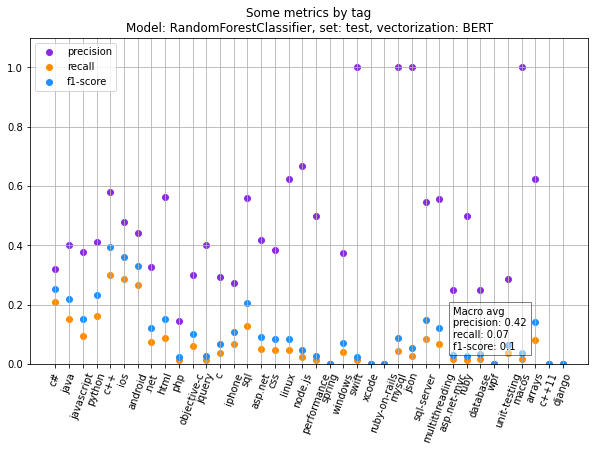

In [104]:
diplay_and_plot_report(y_test, 
                       y_pred_test, 
                       'RandomForestClassifier', 
                       'test',
                       'BERT')

In [105]:
fpr, tpr, roc_auc = compute_roc_data(y_train,
                                     y_pred_train_proba, 
                                     tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
1.00
Macro-averaged One-vs-Rest ROC AUC score:
1.00


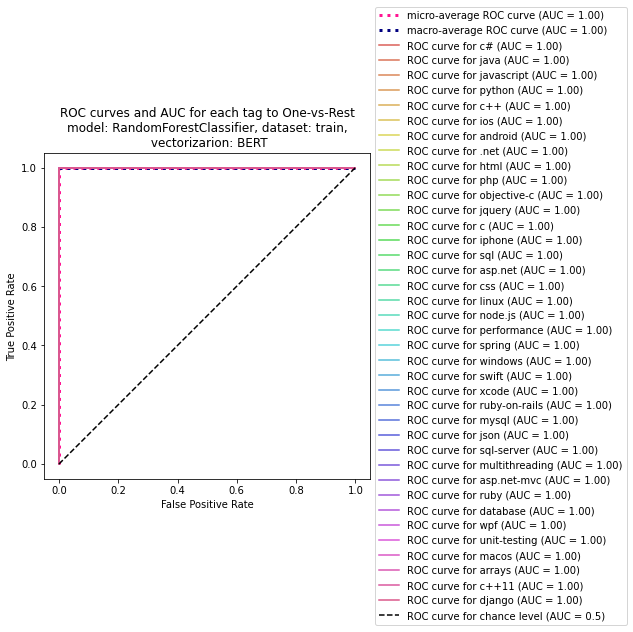

In [106]:
plot_roc_curves(fpr,
                tpr,
                roc_auc,
                'RandomForestClassifier', 
                'train',
                'BERT',
                y_train, 
                y_pred_train_proba)

In [107]:
fpr, tpr, roc_auc = compute_roc_data(y_test,
                                     y_pred_test_proba, 
                                     tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.81
Macro-averaged One-vs-Rest ROC AUC score:
0.76


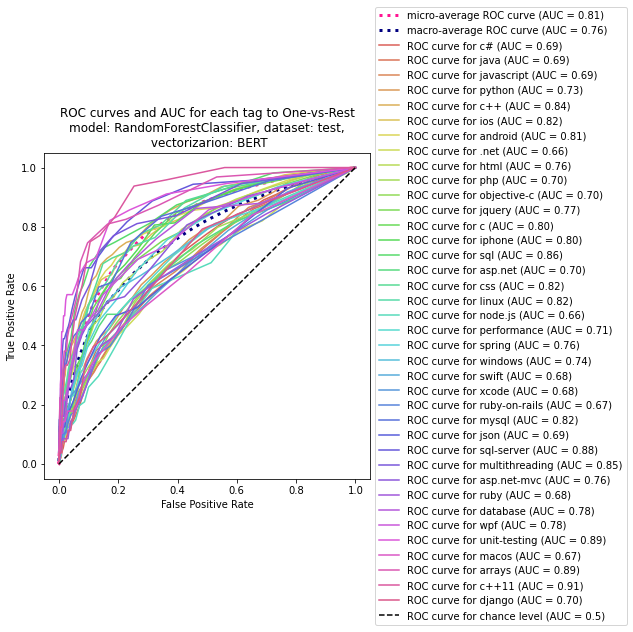

In [108]:
plot_roc_curves(fpr,
                tpr,
                roc_auc,
                'RandomForestClassifier', 
                'test',
                'BERT',
                y_test, 
                y_pred_test_proba)

In [109]:
# Appending results for later compare
append_results(vectorization='BERT',
               model='RandomForest', 
               f1=f1_sco, 
               auc=roc_auc_res,
               fittime=fittime)

In [111]:
display(pd.DataFrame(classification_results))

Vectorization               Model  Macro. avg. f1-score  Macro. avg. AUC  \
0        TF-IDF  LogisticRegression                  0.55             0.95   
1        TF-IDF       MultinomialNB                  0.48             0.93   
2        TF-IDF      RandomForestCl                  0.43             0.92   
3      Word2Vec  LogisticRegression                  0.47             0.92   
4      Word2Vec        RandomForest                  0.15             0.82   
5      Word2Vec       MultinomialNB                  0.20             0.88   
6          BERT  LogisticRegression                  0.47             0.90   
7          BERT        RandomForest                  0.10             0.76   

   Fit time  
0      3.87  
1      3.87  
2     86.42  
3     25.08  
4    401.76  
5    401.76  
6    259.71  
7    984.06

### Naive-Bayes classifier

This classifier does not take negative numbers as an argument for the feature matrix. We then scale the data with min-max scaler to have them between 0 and 1.

In [100]:
# from sklearn.preprocessing import MinMaxScaler

# X = features_bert

# # Scaling data
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

# # Defining target vector
# columns_tags = ['tag_'+tag for tag in tag_list]
# y = df[columns_tags]

# # Splitting into train and test set
# X_train, X_test, y_train, y_test = train_test_split(
#     X_scaled,y, test_size=0.33, random_state=5
# )

In [113]:
parameters = {
    'estimator__alpha' : [0.05, 0.2, 0.5, 1],
    'estimator__fit_prior' : [True, False]
}

# Instantiating OneVsRest Classifier
cl = OneVsRestClassifier(MultinomialNB())

# Grid search for best hyperparameters
grid_search = GridSearchCV(
    estimator = cl,
    param_grid= parameters,
    scoring='roc_auc_ovr',
    verbose=2,
    n_jobs=-1
)

# Performing grid search
grid_search.fit(X_train, y_train)

# Instantiating Best OneVsRest Classifier
cl = grid_search.best_estimator_

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
fittime = finish - start
print(f'fit time: {fittime} secs.')

# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

# Print best parameters
print('The best parameters are:')
print(grid_search.best_params_)
print('The best score is:')
print(grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
fit time: 1.9089934825897217 secs.
predict time: 2.0724940299987793 secs.
The best parameters are:
{'estimator__alpha': 0.05, 'estimator__fit_prior': True}
The best score is:
0.8126718840913613


In [114]:
# Choosing best threshold for classification
thresh = choose_best_thres(y_train, y_pred_train_proba)

# predictions based on threshold
y_pred_train = (y_pred_train_proba > thresh).astype(int)
y_pred_test = (y_pred_test_proba > thresh).astype(int)

Threshold that maximizes f1-score: 0.1


Evaluation: NaiveBayes

Classifier: MultinomialNB	Dataset: train
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       0.19      0.84      0.31      1012
          java       0.17      0.86      0.29       901
    javascript       0.17      0.71      0.28       769
        python       0.19      0.71      0.30       747
           c++       0.23      0.70      0.35       600
           ios       0.24      0.71      0.36       564
       android       0.23      0.73      0.35       507
          .net       0.14      0.48      0.22       526
          html       0.20      0.63      0.30       333
           php       0.37      0.24      0.29       313
   objective-c       0.16      0.52      0.24       292
        jquery       0.19      0.31      0.24       288
             c       0.17      0.52      0.25       240
        iphone       0.17      0.64      0.27       257
           sql       0.23      0.64      0.34  

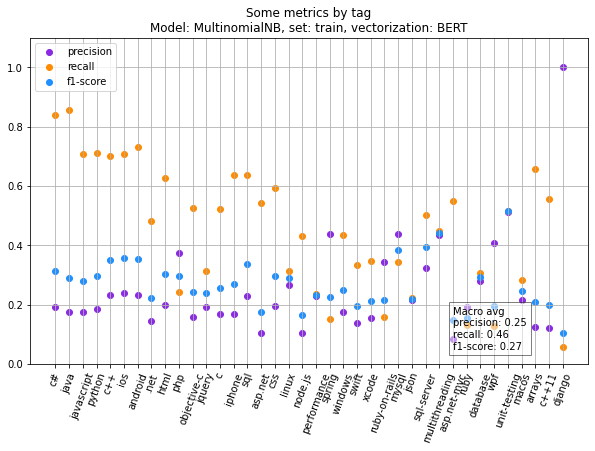

In [115]:
diplay_and_plot_report(y_train, 
                       y_pred_train, 
                       'MultinomialNB', 
                       'train',
                       'BERT')

Classifier: MultinomialNB	Dataset: test
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       0.18      0.85      0.30       467
          java       0.16      0.86      0.28       430
    javascript       0.19      0.69      0.30       409
        python       0.16      0.67      0.26       354
           c++       0.25      0.73      0.37       293
           ios       0.25      0.73      0.37       285
       android       0.23      0.68      0.34       249
          .net       0.14      0.49      0.22       239
          html       0.21      0.51      0.30       206
           php       0.36      0.21      0.27       164
   objective-c       0.14      0.48      0.21       147
        jquery       0.23      0.35      0.28       150
             c       0.16      0.47      0.24       131
        iphone       0.18      0.62      0.27       134
           sql       0.23      0.59      0.33   

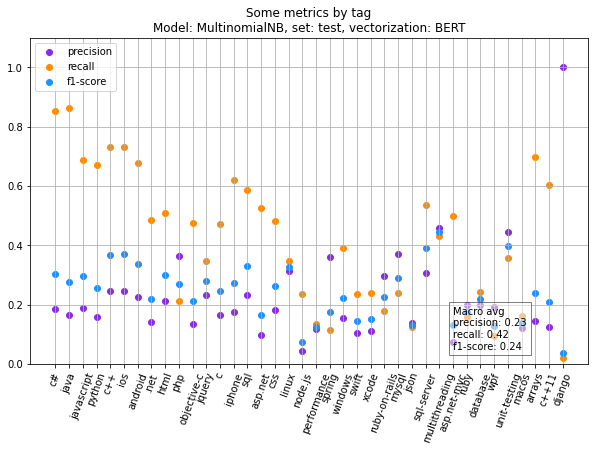

In [116]:
diplay_and_plot_report(y_test, 
                       y_pred_test, 
                       'MultinomialNB', 
                       'test',
                       'BERT')

In [117]:
fpr, tpr, roc_auc = compute_roc_data(y_train,
                                     y_pred_train_proba, 
                                     tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.85
Macro-averaged One-vs-Rest ROC AUC score:
0.83


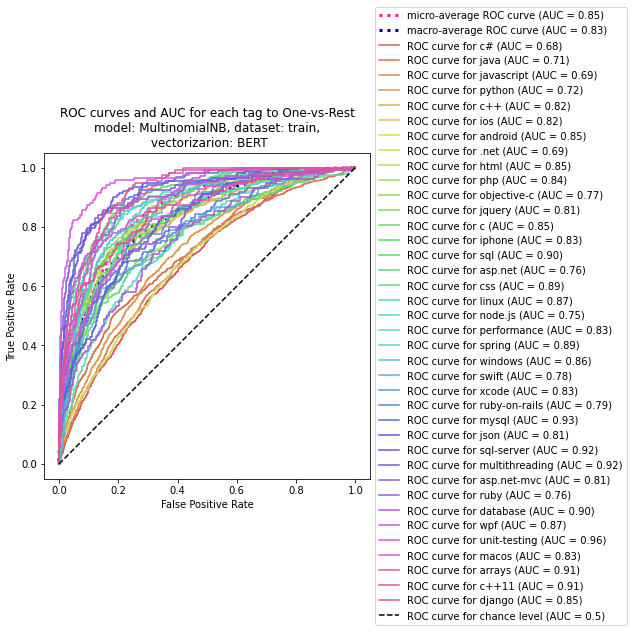

In [118]:
plot_roc_curves(fpr,
                tpr,
                roc_auc,
                'MultinomialNB', 
                'train',
                'BERT',
                y_train, 
                y_pred_train_proba)

In [119]:
fpr, tpr, roc_auc = compute_roc_data(y_test,
                                     y_pred_test_proba, 
                                     tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.84
Macro-averaged One-vs-Rest ROC AUC score:
0.81


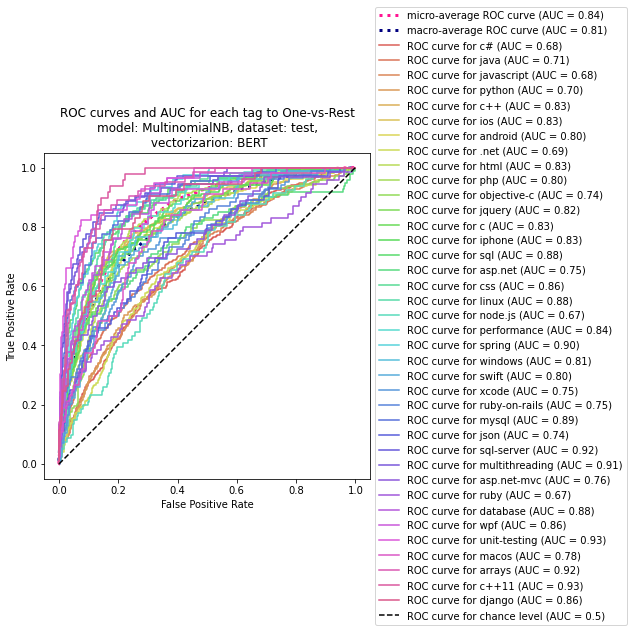

In [120]:
plot_roc_curves(fpr,
                tpr,
                roc_auc,
                'MultinomialNB', 
                'test',
                'BERT',
                y_test, 
                y_pred_test_proba)

In [121]:
# Appending results for later compare
append_results(vectorization='BERT',
               model='MultinomialNB', 
               f1=f1_sco, 
               auc=roc_auc_res,
               fittime=fittime)

# USE (Supervised)

In [122]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [123]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [124]:
batch_size = 10
sentences = df['processed_text'].to_list()
features_USE = feature_USE_fct(sentences, batch_size)

We can now obtain our **feature matrix**:

In [125]:
X = features_USE

# Defining target vector
columns_tags = ['tag_'+tag for tag in tag_list]
y = df[columns_tags]

# Splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.33, random_state=5
)

## Classification

### Logistic Regression

In [126]:
# # Hyperparameters for logistic regression
# parameters = {
#     'estimator__penalty' : ['l1', 'l2'],
#     'estimator__tol' : [1e-6, 1e-5, 1e-4, 1e-3],
#     'estimator__C' : [0.01,0.05 ,0.1, 0.5, 0.7, 1],
#     'estimator__fit_intercept' : [True, False],
#     'estimator__solver' : ['liblinear','sag', 'saga']
# }

# # Instantiating OneVsRest Classifier
# cl = OneVsRestClassifier(LogisticRegression())

# # Random search for best hyperparameters
# random_search = RandomizedSearchCV(
#     estimator = cl,
#     param_distributions= parameters,
#     n_iter=20,
#     scoring='roc_auc_ovr',
#     random_state=5,
#     n_jobs=-1
# )

# # Perform random search
# random_search.fit(X_train, y_train)

# # Instantiating BEST OneVsRest Classifier
# cl = random_search.best_estimator_

# # Fitting classifier
# start = time.time()
# cl.fit(X_train,y_train)
# finish = time.time()
# fittime = finish - start
# print(f'fit time: {fittime} secs.')

# # Predicting (with probabilites)
# start = time.time()
# y_pred_train_proba = cl.predict_proba(X_train)
# finish = time.time()
# print(f'predict time: {finish - start} secs.')

# y_pred_test_proba = cl.predict_proba(X_test)

KeyboardInterrupt: ignored

In [ ]:
# # Print best parameters
# print('The best parameters are:')
# print(random_search.best_params_)
# print('The best score is:')
# print(random_search.best_score_)

The best parameters are:
{'estimator__tol': 0.0001, 'estimator__solver': 'sag', 'estimator__penalty': 'l2', 'estimator__fit_intercept': True, 'estimator__C': 0.05}
The best score is:
0.9245329376227254


In [127]:
# Instantiating OneVsRest Classifier with BEST parameters found
cl = OneVsRestClassifier(LogisticRegression(
    tol=0.0001,
    solver='sag',
    penalty='l2',
    fit_intercept=True,
    C=0.05
))

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
fittime = finish - start
print(f'fit time: {fittime} secs.')

# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

fit time: 19.207165241241455 secs.
predict time: 0.3242807388305664 secs.


In [128]:
thresh = choose_best_thres(y_train, y_pred_train_proba)

# Predictions based on threshold
y_pred_train = (y_pred_train_proba > thresh).astype(int)
y_pred_test = (y_pred_test_proba > thresh).astype(int)

Threshold that maximizes f1-score: 0.1


#### Evaluation: LogisticRegression

Classifier: LogisticRegression	Dataset: train
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       0.25      0.99      0.41      1012
          java       0.23      0.98      0.37       901
    javascript       0.32      0.97      0.48       769
        python       0.36      0.97      0.53       747
           c++       0.37      0.92      0.53       600
           ios       0.39      0.95      0.56       564
       android       0.39      0.93      0.55       507
          .net       0.29      0.84      0.44       526
          html       0.41      0.74      0.53       333
           php       0.78      0.72      0.75       313
   objective-c       0.44      0.47      0.45       292
        jquery       0.54      0.71      0.62       288
             c       0.51      0.36      0.42       240
        iphone       0.45      0.32      0.38       257
           sql       0.83      0.30      0

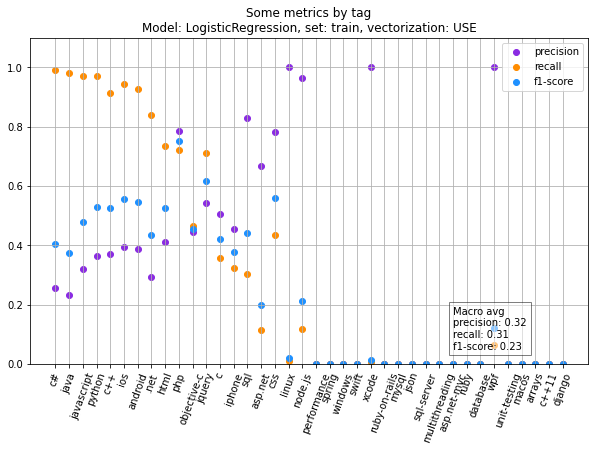

In [129]:
diplay_and_plot_report(y_train, 
                       y_pred_train, 
                       'LogisticRegression', 
                       'train', 
                       'USE')

Classifier: LogisticRegression	Dataset: test
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       0.24      0.99      0.38       467
          java       0.23      0.99      0.37       430
    javascript       0.34      0.98      0.51       409
        python       0.33      0.96      0.50       354
           c++       0.35      0.92      0.51       293
           ios       0.39      0.95      0.55       285
       android       0.38      0.93      0.54       249
          .net       0.28      0.79      0.41       239
          html       0.46      0.72      0.56       206
           php       0.81      0.73      0.77       164
   objective-c       0.37      0.44      0.40       147
        jquery       0.57      0.75      0.65       150
             c       0.41      0.31      0.35       131
        iphone       0.49      0.37      0.42       134
           sql       0.68      0.14      0.

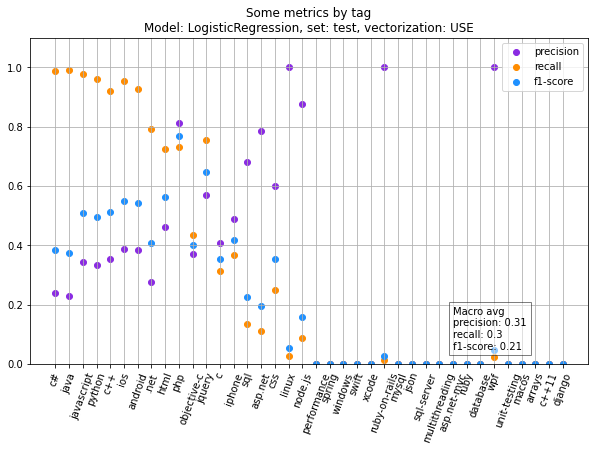

In [130]:
diplay_and_plot_report(y_test, 
                       y_pred_test, 
                       'LogisticRegression', 
                       'test',
                       'USE')

In [131]:
fpr, tpr, roc_auc = compute_roc_data(y_train,
                                     y_pred_train_proba, 
                                     tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.91
Macro-averaged One-vs-Rest ROC AUC score:
0.96


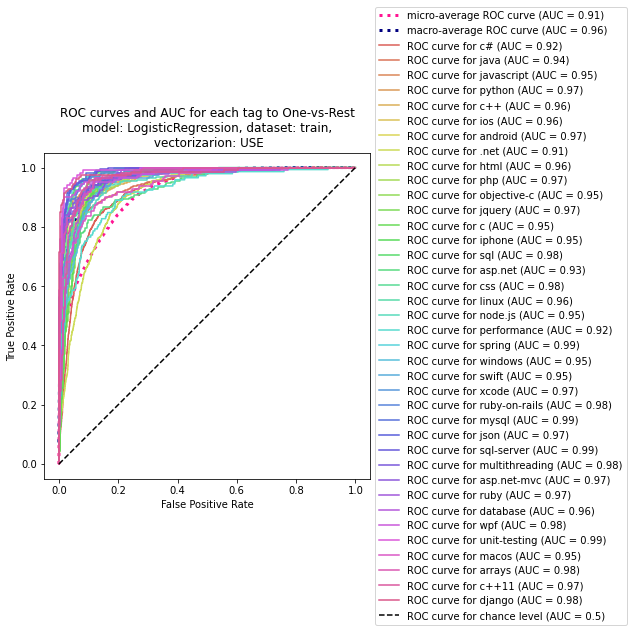

In [132]:
plot_roc_curves(fpr,
                tpr,
                roc_auc,
                'LogisticRegression', 
                'train',
                'USE',
                y_train, 
                y_pred_train_proba)

In [134]:
fpr, tpr, roc_auc = compute_roc_data(y_test,
                                     y_pred_test_proba, 
                                     tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.91
Macro-averaged One-vs-Rest ROC AUC score:
0.96


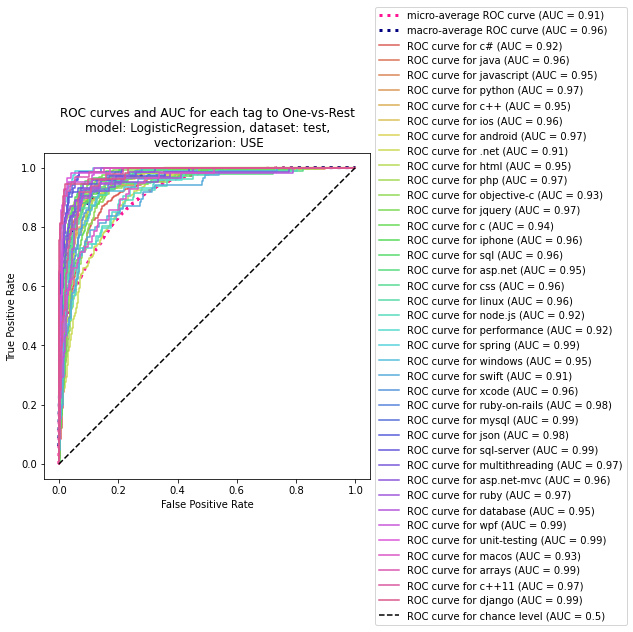

In [135]:
plot_roc_curves(fpr,
                tpr,
                roc_auc,
                'LogisticRegression', 
                'test',
                'USE',
                y_test, 
                y_pred_test_proba)

In [136]:
# Appending results for later compare
append_results(vectorization='USE',
               model='LogisticRegression', 
               f1=f1_sco, 
               auc=roc_auc_res,
               fittime=fittime)

### RandomForest


In [137]:
# Instantiating OneVsRest Classifier default parameters
cl = OneVsRestClassifier(RandomForestClassifier())

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
fittime = finish - start
print(f'fit time: {fittime} secs.')

# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

fit time: 443.5197947025299 secs.
predict time: 3.4274206161499023 secs.


In [138]:
# choose threshold for maximal f1-score
thresh = choose_best_thres(y_train, y_pred_train_proba)

# predictions based on threshold
y_pred_train = (y_pred_train_proba > thresh).astype(int)
y_pred_test = (y_pred_test_proba > thresh).astype(int)

Threshold that maximizes f1-score: 0.4


#### Evaluation: RandomForestClassifier

Classifier: RandomForestClassifier	Dataset: train
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       1.00      1.00      1.00      1012
          java       1.00      1.00      1.00       901
    javascript       1.00      1.00      1.00       769
        python       1.00      1.00      1.00       747
           c++       1.00      1.00      1.00       600
           ios       1.00      1.00      1.00       564
       android       1.00      1.00      1.00       507
          .net       1.00      1.00      1.00       526
          html       1.00      1.00      1.00       333
           php       1.00      1.00      1.00       313
   objective-c       1.00      1.00      1.00       292
        jquery       1.00      1.00      1.00       288
             c       1.00      1.00      1.00       240
        iphone       1.00      1.00      1.00       257
           sql       1.00      1.00   

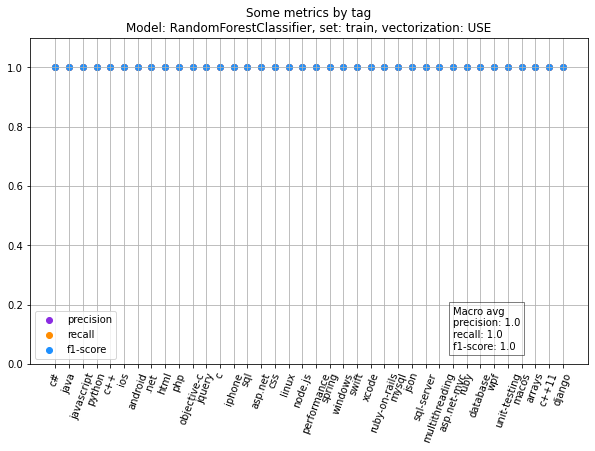

In [139]:
diplay_and_plot_report(y_train, 
                       y_pred_train, 
                       'RandomForestClassifier', 
                       'train',
                       'USE')

Classifier: RandomForestClassifier	Dataset: test
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       0.71      0.51      0.60       467
          java       0.90      0.63      0.74       430
    javascript       0.75      0.60      0.67       409
        python       0.93      0.64      0.76       354
           c++       0.78      0.53      0.63       293
           ios       0.73      0.63      0.68       285
       android       0.97      0.61      0.75       249
          .net       0.67      0.12      0.21       239
          html       0.59      0.21      0.31       206
           php       0.91      0.59      0.71       164
   objective-c       0.56      0.16      0.25       147
        jquery       0.86      0.39      0.54       150
             c       0.62      0.06      0.11       131
        iphone       0.74      0.19      0.30       134
           sql       0.68      0.31    

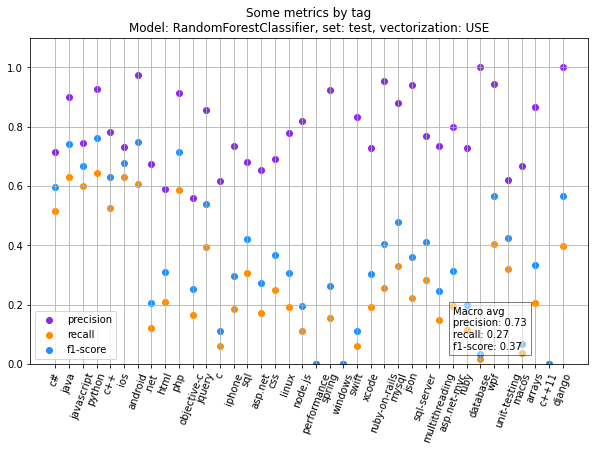

In [140]:
diplay_and_plot_report(y_test, 
                       y_pred_test, 
                       'RandomForestClassifier', 
                       'test',
                       'USE')

In [141]:
fpr, tpr, roc_auc = compute_roc_data(y_train,
                                     y_pred_train_proba, 
                                     tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
1.00
Macro-averaged One-vs-Rest ROC AUC score:
1.00


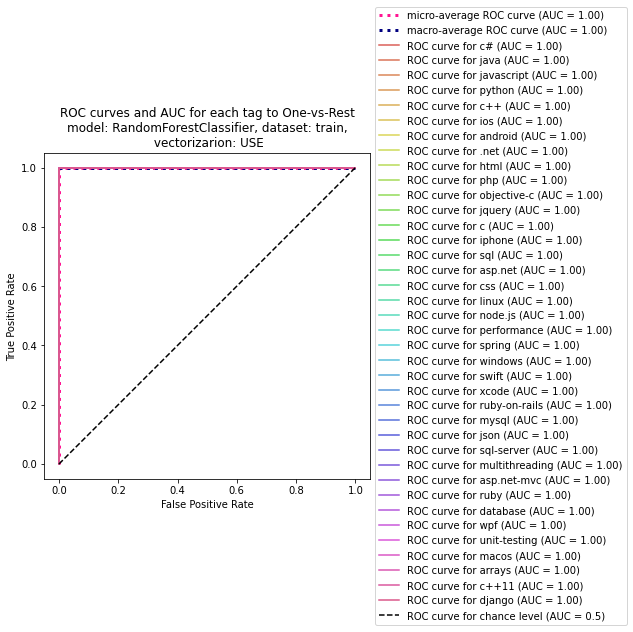

In [142]:
plot_roc_curves(fpr,
                tpr,
                roc_auc,
                'RandomForestClassifier', 
                'train',
                'USE',
                y_train, 
                y_pred_train_proba)

In [143]:
fpr, tpr, roc_auc = compute_roc_data(y_test,
                                     y_pred_test_proba, 
                                     tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.95
Macro-averaged One-vs-Rest ROC AUC score:
0.94


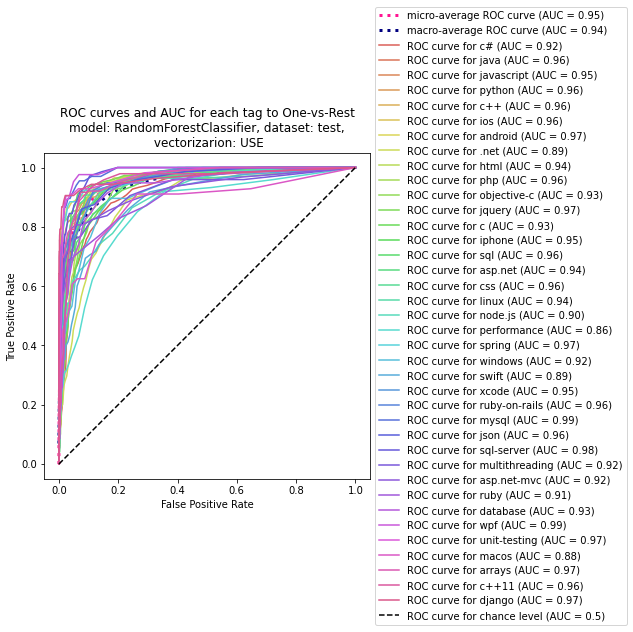

In [144]:
plot_roc_curves(fpr,
                tpr,
                roc_auc,
                'RandomForestClassifier', 
                'test',
                'USE',
                y_test, 
                y_pred_test_proba)

In [145]:
# Appending results for later compare
append_results(vectorization='USE',
               model='RandomForest', 
               f1=f1_sco, 
               auc=roc_auc_res,
               fittime=fittime)

### Naive-Bayes classifier (TD-IDF)

This classifier does not take negative numbers as an argument for the feature matrix. We then scale the data with min-max scaler to have them between 0 and 1.

In [147]:
from sklearn.preprocessing import MinMaxScaler

X = features_USE

# Scaling data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Defining target vector
columns_tags = ['tag_'+tag for tag in tag_list]
y = df[columns_tags]

# Splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,y, test_size=0.33, random_state=5
)

We now do a random search for the best parameters

In [148]:
parameters = {
    'estimator__alpha' : [0.05, 0.2, 0.5, 1],
    'estimator__fit_prior' : [True, False]
}

# Instantiating OneVsRest Classifier
cl = OneVsRestClassifier(MultinomialNB())

# Grid search for best hyperparameters
grid_search = GridSearchCV(
    estimator = cl,
    param_grid= parameters,
    scoring='roc_auc_ovr',
    verbose=2,
    n_jobs=-1
)

# Performing grid search
grid_search.fit(X_train, y_train)

# Instantiating Best OneVsRest Classifier
cl = grid_search.best_estimator_

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
fittime = finish - start
print(f'fit time: {fittime} secs.')

# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

# Print best parameters
print('The best parameters are:')
print(grid_search.best_params_)
print('The best score is:')
print(grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
fit time: 0.6207373142242432 secs.
predict time: 0.5617990493774414 secs.
The best parameters are:
{'estimator__alpha': 1, 'estimator__fit_prior': True}
The best score is:
0.9541125188054655


In [149]:
# Choosing best threshold for classification
thresh = choose_best_thres(y_train, y_pred_train_proba)

# predictions based on threshold
y_pred_train = (y_pred_train_proba > thresh).astype(int)
y_pred_test = (y_pred_test_proba > thresh).astype(int)

Threshold that maximizes f1-score: 0.5


#### Evaluation: NaiveBayes

Classifier: MultinomialNB	Dataset: train
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       0.64      0.57      0.61      1012
          java       0.86      0.52      0.65       901
    javascript       0.64      0.69      0.66       769
        python       0.92      0.72      0.81       747
           c++       0.63      0.72      0.67       600
           ios       0.61      0.70      0.66       564
       android       0.66      0.73      0.69       507
          .net       0.44      0.44      0.44       526
          html       0.43      0.66      0.52       333
           php       0.78      0.68      0.73       313
   objective-c       0.37      0.56      0.45       292
        jquery       0.50      0.73      0.59       288
             c       0.33      0.68      0.44       240
        iphone       0.34      0.61      0.44       257
           sql       0.45      0.80      0.57  

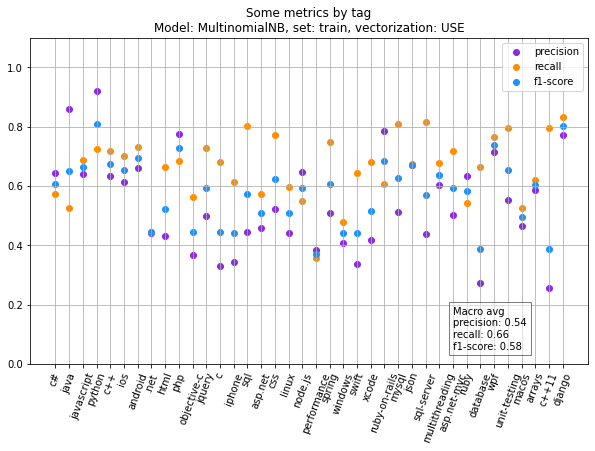

In [150]:
diplay_and_plot_report(y_train, 
                       y_pred_train, 
                       'MultinomialNB', 
                       'train',
                       'USE')

Classifier: MultinomialNB	Dataset: test
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       0.66      0.55      0.60       467
          java       0.86      0.57      0.69       430
    javascript       0.66      0.68      0.67       409
        python       0.89      0.66      0.76       354
           c++       0.58      0.68      0.63       293
           ios       0.57      0.70      0.63       285
       android       0.66      0.71      0.68       249
          .net       0.44      0.39      0.42       239
          html       0.48      0.66      0.56       206
           php       0.79      0.71      0.75       164
   objective-c       0.33      0.52      0.40       147
        jquery       0.51      0.77      0.61       150
             c       0.32      0.66      0.43       131
        iphone       0.39      0.72      0.51       134
           sql       0.46      0.73      0.56   

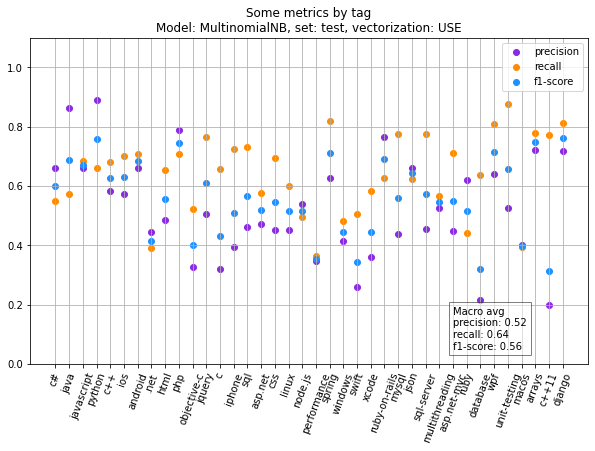

In [151]:
diplay_and_plot_report(y_test, 
                       y_pred_test, 
                       'MultinomialNB', 
                       'test',
                       'USE')

In [152]:
fpr, tpr, roc_auc = compute_roc_data(y_train,
                                     y_pred_train_proba, 
                                     tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.96
Macro-averaged One-vs-Rest ROC AUC score:
0.96


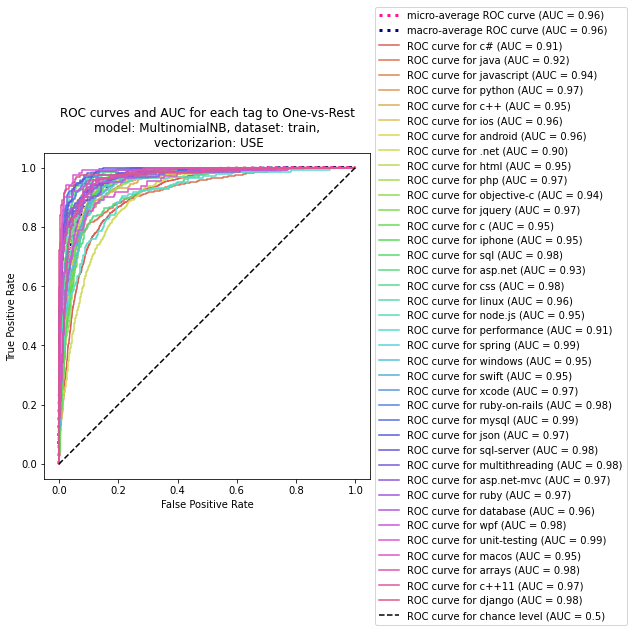

In [153]:
plot_roc_curves(fpr,
                tpr,
                roc_auc,
                'MultinomialNB', 
                'train',
                'USE',
                y_train, 
                y_pred_train_proba)

In [154]:
fpr, tpr, roc_auc = compute_roc_data(y_test,
                                     y_pred_test_proba, 
                                     tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.96
Macro-averaged One-vs-Rest ROC AUC score:
0.96


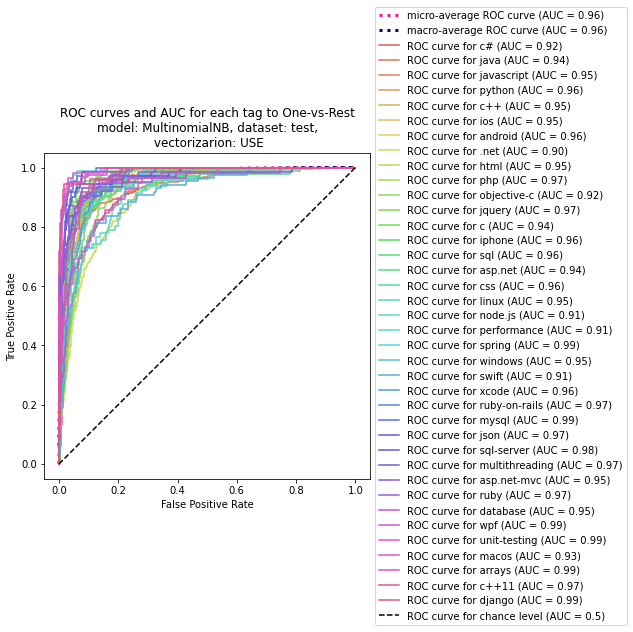

In [155]:
plot_roc_curves(fpr,
                tpr,
                roc_auc,
                'MultinomialNB', 
                'test',
                'USE',
                y_test, 
                y_pred_test_proba)

In [156]:
# Appending results for later compare
append_results(vectorization='USE',
               model='MultinomialNB', 
               f1=f1_sco, 
               auc=roc_auc_res,
               fittime=fittime)

# Comparing supervised models

In [159]:
cl_results_df = pd.DataFrame(classification_results)
cl_results_df.to_csv('classification_results.csv')
display(cl_results_df)

Vectorization               Model  Macro. avg. f1-score  Macro. avg. AUC  \
0         TF-IDF  LogisticRegression                  0.55             0.95   
1         TF-IDF       MultinomialNB                  0.48             0.93   
2         TF-IDF      RandomForestCl                  0.43             0.92   
3       Word2Vec  LogisticRegression                  0.47             0.92   
4       Word2Vec        RandomForest                  0.15             0.82   
5       Word2Vec       MultinomialNB                  0.20             0.88   
6           BERT  LogisticRegression                  0.47             0.90   
7           BERT        RandomForest                  0.10             0.76   
8           BERT       MultinomialNB                  0.24             0.81   
9            USE  LogisticRegression                  0.21             0.96   
10           USE        RandomForest                  0.37             0.94   
11           USE       MultinomialNB                  0.56             0.96   

    Fit time  
0       3.87  
1       3.87  
2      86.42  
3      25.08  
4     401.76  
5     401.76  
6     259.71  
7     984.06  
8       1.91  
9      19.21  
10    443.52  
11      0.62

In [166]:
import plotly.express as px

fig = px.scatter(cl_results_df,
                 x='Macro. avg. AUC',
                 y='Macro. avg. f1-score',
                 hover_data=['Macro. avg. AUC',
                             'Macro. avg. f1-score',
                             'Vectorization',
                             'Model',
                             'Fit time'])
fig.show()

# LDA (Non-supervised)

For the topic prediction with the Latent Dirichlet Allocation model, we need to first convert the documents into document-term matrix. We choose to use TF-IDF form.

In [169]:
pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.3 MB/s eta 0:00:00


In [11]:
# Instantiate the tf-idf vectorizer
tfidf = TfidfVectorizer(max_df=0.75,
                        min_df=0.001)
# Vectorize the processed text
X_tfidf = tfidf.fit_transform(df.processed_text)
print(f'Shape of tf-idf document-term matrix: {X_tfidf.shape}')


Shape of tf-idf document-term matrix: (10000, 2592)


As phrased in the [scikit-learn user guide](https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation) for Latent Dirichlet Allocation:

>  LDA is a generative probabilistic model for collections of discrete dataset such as text corpora. It is also a topic model that is used for discovering abstract topics from a collection of documents.

With this scikit-learn implementation of LDA, we are then going to obtain a classification of our texts into topics. Concretely, we chose the number of different topics (this is an hyperparameter), the trained model will provide a **"topic-term" matrix** and a **"document-topic" matrix** can be calculated using its `transform` method.

We think that this model does not fit our main purpose which is more a multilabel classification. There are two main reasons for this opinion: one is that, in practice, we have many different tags (in our computation we have around 40 but in a sample of 50 000 documents we can have 18 000 different tags), and as we will see in the hyperparameter search, the optimal number of topics (`n_components`) is very low (between 5 and 10) compared to the number of tags (here 40). The second reason is that LDA seem to provide and be optimal for a **disjoint** set of topics, whereas in our purpose of tag suggestion, there are many tag that intersect. 

Take for example the tags **windows**, **linux**, and **python**. There are many questions that will be tagged with either **windows** and **python**, or either **linux** and **python**, or even the three of them. So to our eyes, it does not makes sense to try to find a disjoint union of topics within our documents.

For these reasons, this model is not chosen as the main model for tag suggestion. However, since for this project it was specifically asked to use LDA, we compute and search for the best hyperparameters and find what are the general topics. To each of the topics found by the model we suggest a list of tags associated to the topic.


In [83]:
param_results = param_search_LDA(X_tfidf, 3, 25)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [86]:
param_results

Silhouette score  Calinski-Harabasz score
n_components                                           
3                         0.65             25933.217102
4                         0.67             21307.874323
5                         0.69             18938.433082
6                         0.66             13517.701852
7                         0.64             10699.970264
8                         0.67             10937.396297
9                         0.65              8758.816113
10                        0.63              7444.243799
11                        0.63              6796.782765
12                        0.60              5421.253699
13                        0.57              4723.498216
14                        0.57              4283.334751
15                        0.56              3853.800891
16                        0.56              3637.281578
17                        0.53              3051.249811
18                        0.54              3047.067533
19                        0.54              2840.794702
20                        0.52              2546.675213
21                        0.51              2292.764562
22                        0.52              2305.657727
23                        0.51              2226.640486
24                        0.51              2088.129488

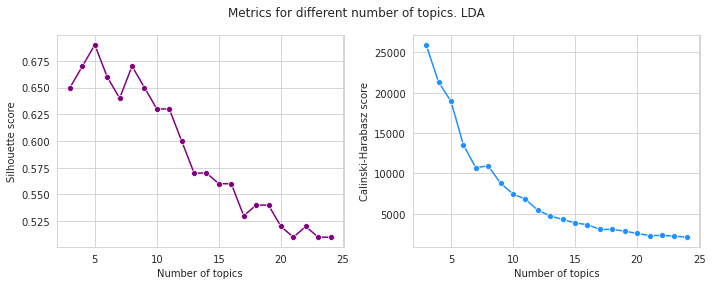

In [87]:
plot_LDA_scores(param_results)

In [115]:
# fitting LDA
lda_tfidf = LatentDirichletAllocation(n_components=8, 
                                      random_state=0)
lda_tfidf.fit(X_tfidf)

LatentDirichletAllocation(n_components=8, random_state=0)

Visualizing the models with pyLDAvis

In [109]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_tfidf, X_tfidf, tfidf, mds='tsne')

PreparedData(topic_coordinates=                x          y  topics  cluster       Freq
topic                                                   
4      -24.437799 -12.224674       1        1  14.949345
28     -54.118572   1.555143       2        1   9.055112
39     -45.083920  24.039738       3        1   8.267761
19     -67.191620 -43.623764       4        1   5.969516
24     -42.473915 -61.839249       5        1   5.678541
33    -108.640770  -0.880041       6        1   4.305934
21     -26.236992 -41.705238       7        1   4.023583
38     -48.636852 -23.261086       8        1   3.943007
29     -83.024643 -14.931216       9        1   3.398217
25     -60.864025  47.272839      10        1   2.978420
1       -8.737875 -74.858498      11        1   2.762042
10     -16.822054  15.005730      12        1   2.139529
37     -28.566586  49.463509      13        1   2.047275
7      -36.037853  81.108322      14        1   1.962076
26    -100.989586  47.862011      15        1   1.893659
27     -78.159927  21.980555      16        1   1.823714
32     -78.211945 -74.554832      17        1   1.674944
31     -42.531643 -94.289604      18        1   1.548859
20       9.287222  -1.288064      19        1   1.494458
16      -0.433263 -30.981302      20        1   1.346870
14     -76.522606  77.091087      21        1   1.273862
22    -109.864716 -46.935040      22        1   1.235469
13      37.652153 -18.460714      23        1   1.133939
6       62.155510 -52.347279      24        1   1.109257
2      100.231567 -46.052979      25        1   1.101063
30      30.984484 -90.519737      26        1   1.067935
35     132.861176  -5.977783      27        1   1.049818
15      15.596950  41.406975      28        1   1.002605
0       14.076272  82.703064      29        1   0.999768
23      26.515898 -45.664780      30        1   0.958361
9      122.273163  48.776211      31        1   0.909704
36      86.865501  87.957176      32        1   0.900429
8       69.369049  -8.299917      33        1   0.808535
11      51.128990  72.192825      34        1   0.800738
5       79.821236  55.113415      35        1   0.768062
12      96.844116   0.377403      36        1   0.763895
18      49.891602  43.813889      37        1   0.748426
17      98.467583  28.885033      38        1   0.725417
3       45.773121  15.650255      39        1   0.714656
34      70.910408  24.306780      40        1   0.665196, topic_info=          Term        Freq       Total Category  logprob  loglift
1052     image  135.000000  135.000000  Default  30.0000  30.0000
2289      test  138.000000  138.000000  Default  29.0000  29.0000
2145    spring   67.000000   67.000000  Default  28.0000  28.0000
542       date   59.000000   59.000000  Default  27.0000  27.0000
2049    server  127.000000  127.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1343  markdown    1.051232    4.757297  Topic40  -5.5628   3.5031
2335     today    3.025456   15.583391  Topic40  -4.5057   3.3737
394    compare    4.682985   27.556345  Topic40  -4.0689   3.2405
1916     reset    1.565498    9.740377  Topic40  -5.1646   3.1848
1969      ruby    2.043213   35.443134  Topic40  -4.8983   2.1594

[1924 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1        30  0.512375          abc
3         4  0.289272        abort
3        40  0.289272        abort
4        20  0.597584     abstract
5         4  0.256520  abstraction
...     ...       ...          ...
2589     37  0.655735          zip
2590     18  0.368468         zone
2590     19  0.491290         zone
2591      6  0.744146         zoom
2591     31  0.186037         zoom

[6385 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 29, 40, 20, 25, 34, 22, 39, 30, 26, 2, 11, 38, 8, 27, 28, 33, 32, 21, 17, 15, 23, 14, 7, 3, 31, 36, 16, 1, 24, 10, 37, 9, 12, 6, 13, 19, 18, 4, 35])

In [114]:
# Creating list of 30 most popular words per topic
words_topic = {}
for index,topic in enumerate(lda_tfidf.components_):
    words_topic[index] = [tfidf.get_feature_names()[i] for i in topic.argsort()[-30:]]

# Intersect this list with our tag official tag list
topics_tags = {}
for topic in words_topic:
    topics_tags[topic] = list(set(words_topic[topic]).intersection(tag_list))

for key,value in topics_tags.items():
    print(f'Topic # {key}, Tags: {value}')

# Counting empty tag set
number_empty_tag_topic = 0
for key,value in topics_tags.items():
    if len(value) == 0:
        number_empty_tag_topic += 1

print(f'The # of topics with empty intersection with tags: {number_empty_tag_topic}')


Topic # 0, Tags: ['spring']
Topic # 1, Tags: ['jquery', 'json', 'javascript']
Topic # 2, Tags: []
Topic # 3, Tags: ['jquery']
Topic # 4, Tags: ['java']
Topic # 5, Tags: []
Topic # 6, Tags: ['spring', 'json']
Topic # 7, Tags: ['swift', 'iphone', 'ios', 'xcode']
Topic # 8, Tags: []
Topic # 9, Tags: []
Topic # 10, Tags: []
Topic # 11, Tags: ['python']
Topic # 12, Tags: []
Topic # 13, Tags: []
Topic # 14, Tags: []
Topic # 15, Tags: []
Topic # 16, Tags: []
Topic # 17, Tags: ['python']
Topic # 18, Tags: ['iphone']
Topic # 19, Tags: ['mysql', 'sql', 'database']
Topic # 20, Tags: ['python']
Topic # 21, Tags: ['performance', 'python']
Topic # 22, Tags: ['java']
Topic # 23, Tags: []
Topic # 24, Tags: ['python']
Topic # 25, Tags: ['android', 'python', 'xcode']
Topic # 26, Tags: ['java', 'android']
Topic # 27, Tags: ['iphone', 'ios', 'xcode', 'django']
Topic # 28, Tags: ['html', 'python']
Topic # 29, Tags: ['html', 'jquery', 'javascript']
Topic # 30, Tags: ['java']
Topic # 31, Tags: ['java', 'php'

For n_components=40 

In [ ]:
words_topic = []

for index,topic in enumerate(lda_tfidf.components_):
    print(f'Topic #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-10:]],'\n')

In [42]:
topic_assignments = lda_tfidf.transform(X_tfidf)
labels = np.argmax(topic_assignments, axis=1)

In [46]:
labels.shape

(10000,)